In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE
import librosa
import os

In [4]:
labels_new = pd.read_csv('labels_new.csv')
display(labels_new.head())

filename    genre
0  m00248.wav    metal
1  m00230.wav  country
2  m00637.wav   hiphop
3  m00627.wav    metal
4  m00138.wav   reggae

## Feature Engineering

In [5]:
# Function to extract features from audio files
def extract_features(file_path):
    audio_data, sr = librosa.load(file_path)
    
    tempo, beats = librosa.beat.beat_track(y=audio_data, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
    rms = librosa.feature.rms(y=audio_data)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr)
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio_data), sr=sr)
    
    mean_centroid = spectral_centroid.mean()
    mean_bandwidth = spectral_bandwidth.mean()
    mean_rms = rms.mean()
    mean_zcr = zcr.mean()
    mean_mfccs = [mfcc.mean() for mfcc in mfccs]
    mean_chroma = chroma.mean()
    mean_contrast = spectral_contrast.mean(axis=1) # Mean along frequency axis
    mean_tonnetz = tonnetz.mean()
    
    return {
        'File': os.path.basename(file_path),
        'Tempo': tempo,
        'Mean Spectral Centroid': mean_centroid,
        'Mean Spectral Bandwidth': mean_bandwidth,
        'Mean RMS Energy': mean_rms,
        'Mean Zero Crossing Rate': mean_zcr,
        'Mean MFCC 1': mean_mfccs[0],  # Assuming 1st MFCC
        'Mean Chroma': mean_chroma.mean(),  # Mean across chroma features
        'Mean Spectral Contrast': mean_contrast.mean(),  # Mean spectral contrast
        'Mean Tonnetz': mean_tonnetz.mean()  # Mean across tonnetz features
        # Add more features or modify as needed
    }


### Uitleg Features:

#### Tempo:
Tempo is hier het geschatten aantal beats per minute van de audio

Voor elk van de volgende features wordt het gemiddelde afgenomen.
#### Sprectral Centroid:
Geeft aan waar het zwaartepunt van het spectrum is en geeft inzicht in de helderheid en toonkarakter van de audio, de formule hiervan gaat als volgt:
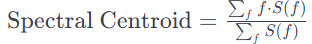
Hierbij is f de frequentie en S(f) de magnitude van het spectrum op frequentie f. 
#### Spectral Bandwith:
Dit is de breedte van het spectrale bereik, het geeft dus gegevens over de spreiding van frequenties in het spectrum. Het wordt op de volgende manier berekent:
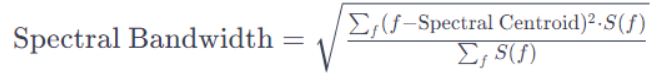
Hier zijn de f en S(f) hetzelfde als bij de Spectral Centroid.
#### Root Mean Square (RMS):
De root mean square is een maat voor de hele amplitude van het signaal. Het wordt op de volgende manier berekent: 
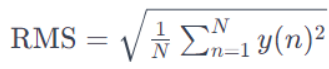
Hierbij is N het aantal samples in het signaal.
#### Zero Crossing Rate (ZCR):
Hiermee wordt de snelheid van nuldoorgangen in het signaal gegeven. Dit geeft inzicht in het 'lawaaierigheid' van de audio. Het wordt bepaald door de aantal keer dat het signaal de nullijn kruist, dit wordt nog genormaliseerd per tijdeinheid.
#### Mel-Frequency Cepstral Coefficients (MFCC):
Dit zijn coëfficiënten die de vorm van het korte-termijnspectrum van het signaal laten zien. Het wordt berekent doormiddel van deze formule:
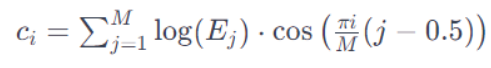
Hierbij is M het aantal filters in de Mel-filterbank en Ej de energie in het j-de filter van de Mel-filterbank is.
#### Chroma Short-Time Fourier Transform (Chroma):
Dit laat de verdeling van de muzieknoten in een signaal zien. Dit wordt berekent door met een korte tijd Fourier-transformatie de frequentiecomponenten van het signaal te weer geven en laat ze dan zien in elk van de 12 chroma-banden.
#### Spectrale Contrast:
Dit is het verschil tussen pieken en dalen in het spectrum, dit wordt berekent op de volgende manier:
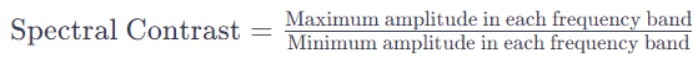
#### Tonnetz:
Is de relatieve sterkte van harmonische componenten in een signaal en legt de relaties tussen de verschillende tonen vast. Dit wordt berekent door het harmonische signaal te transformeren naar de tonnetz-ruimte, de tonnetz-ruimte zet dan de relaties tussen tonen vast.
[ChatGPT, 2024, Prompt: Features (sorry numpy werkte eerste niet)](https://chat.openai.com/share/65be9719-331f-412c-a338-e7233af59b13)

In [6]:
labeled_path = 'J:\machine learning audio\labeled'
audio_file_paths = [labeled_path + '/' + str(file) for file in labels_new['filename']]
labeled_features = [extract_features(file) for file in audio_file_paths]

audio_features = pd.DataFrame(labeled_features)
audio_labeled = audio_features.copy()
audio_labeled = audio_labeled.merge(labels_new, left_on='File', right_on='filename')
audio_labeled.set_index('File', inplace=True)
audio_labeled.drop('filename', axis=1, inplace=True)

display(audio_labeled)

Tempo  Mean Spectral Centroid  Mean Spectral Bandwidth  \
File                                                                      
m00248.wav  107.666016             2656.941556              2337.704931   
m00230.wav  123.046875             3760.408113              3052.844395   
m00637.wav  107.666016             2290.939647              2181.566339   
m00627.wav  123.046875             2378.492400              2092.421780   
m00138.wav  123.046875             1995.276965              2295.684097   
m00192.wav  129.199219             1878.494004              1964.814673   
m00429.wav  151.999081             2272.540503              2327.148207   
m00623.wav  112.347147             3089.748473              2973.746995   
m00002.wav  129.199219             1451.862124              1920.270843   
m00039.wav  135.999178             1811.410394              2019.300256   
m00677.wav  117.453835             1425.279703              1691.007486   
m00867.wav  117.453835             2006.827265              2068.839259   
m00503.wav  129.199219             2464.290893              2037.687558   
m00421.wav   89.102909             3728.389159              3224.634259   
m00501.wav  151.999081             1725.617187              2091.106238   
m00801.wav  123.046875             2946.632607              3203.143085   
m00400.wav   58.726918              570.349904               995.505853   
m00629.wav  129.199219             1881.220510              2116.164563   
m00762.wav  112.347147             2908.674645              2990.137959   
m00895.wav   92.285156             2344.525924              2374.883722   
m00678.wav  151.999081             2241.159283              2115.949177   
m00671.wav   75.999540             2004.658416              2297.795833   
m00206.wav  112.347147             2735.685145              2295.501868   
m00676.wav  117.453835             2568.447243              2558.809407   
m00821.wav  184.570312             3048.922050              2358.945157   
m00112.wav  151.999081             2112.968319              2595.225720   
m00773.wav  107.666016             2053.421991              2559.297984   
m00313.wav   92.285156             1109.320763              1463.110786   
m00633.wav  117.453835             1879.437181              2085.362339   
m00072.wav  129.199219             2624.814629              2709.897108   
m00996.wav   99.384014             1337.777104              1518.833999   
m00716.wav  103.359375             2034.491720              2084.482331   
m00351.wav   99.384014             1825.791993              2108.133619   
m00606.wav   89.102909             1470.219043              1960.209861   
m00096.wav  123.046875             2549.269757              2485.524548   
m00454.wav  123.046875             2669.947536              2396.503479   
m00553.wav  117.453835             2117.600894              2143.866831   
m00772.wav  129.199219             2077.565822              1927.228013   
m00658.wav  103.359375             2629.044979              2350.816186   
m00338.wav   99.384014             1977.095717              1927.701207   
m00298.wav   80.749512             1817.230590              1973.792039   
m00850.wav  135.999178             2606.299127              2534.060693   
m00513.wav  129.199219             4052.736285              3426.415990   
m00041.wav   95.703125             3110.898196              2992.010638   
m00339.wav  129.199219             2471.453752              2102.193465   
m00253.wav   78.302557             2442.941258              2358.665888   
m00435.wav  135.999178             1623.758025              1551.132227   
m00236.wav  123.046875             1329.456363              1415.598178   
m00102.wav  123.046875             1174.324842              1518.126210   
m00477.wav  117.453835             1171.477079              1466.896056   

            Mean RMS Energy  Mean Zero Crossing Rate  Mean MFCC 1  \
File                                           

In [7]:
directory = 'J:/machine learning audio/unlabeled'

# Get all files in the directory
audio_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.wav')]

unlabeled_features = [extract_features(file) for file in audio_files]
audio_features = pd.DataFrame(unlabeled_features)
audio_features.set_index('File', inplace=True)
audio_unlabeled = audio_features.copy()

display(audio_unlabeled)

Tempo  Mean Spectral Centroid  Mean Spectral Bandwidth  \
File                                                                      
m00003.wav  135.999178             2254.606986              2071.028440   
m00012.wav  103.359375             2908.300131              2286.252592   
m00013.wav  184.570312             1952.607933              1865.996047   
m00043.wav  135.999178             2384.634958              2072.759900   
m00044.wav  143.554688              790.507005               900.409298   
...                ...                     ...                      ...   
m00971.wav  107.666016             1525.791709              1588.217850   
m00973.wav  129.199219             3669.810467              3295.063699   
m00988.wav  103.359375             3941.417696              3361.641125   
m00991.wav   95.703125              983.971719              1404.408041   
m00995.wav  151.999081             1253.032399              1371.258170   

            Mean RMS Energy  Mean Zero Crossing Rate  Mean MFCC 1  \
File                                                                
m00003.wav         0.136221                 0.120116   -82.511116   
m00012.wav         0.217475                 0.178108    -1.913298   
m00013.wav         0.029083                 0.123423  -287.603699   
m00043.wav         0.100411                 0.126073  -120.147491   
m00044.wav         0.018833                 0.052088  -437.604401   
...                     ...                      ...          ...   
m00971.wav         0.038885                 0.091590  -246.158646   
m00973.wav         0.259782                 0.161797    -8.573005   
m00988.wav         0.240724                 0.167480   -56.153061   
m00991.wav         0.017138                 0.044217  -406.846680   
m00995.wav         0.066664                 0.071629  -223.187332   

            Mean Chroma  Mean Spectral Contrast  Mean Tonnetz  
File                                                           
m00003.wav     0.469243               20.380788      0.019258  
m00012.wav     0.431165               20.044021     -0.000020  
m00013.wav     0.289961               23.250822      0.009197  
m00043.wav     0.465585               19.720750      0.030229  
m00044.wav     0.217778               20.252849     -0.030368  
...                 ...                     ...           ...  
m00971.wav     0.309741               19.058683      0.041601  
m00973.wav     0.423550               17.701767     -0.024535  
m00988.wav     0.433070               17.446198     -0.002433  
m00991.wav     0.267299               23.256242      0.007466  
m00995.wav     0.253279               23.350275      0.011575  

[105 rows x 9 columns]

## Unsupervised Learning

In [8]:
scaler = StandardScaler()
audio_unlabeled_scaled = scaler.fit_transform(audio_unlabeled)
audio_unlabeled_scaled = pd.DataFrame(audio_unlabeled_scaled, columns=audio_unlabeled.columns)
audio_labeled_scaled = scaler.fit_transform(audio_labeled.drop('genre', axis=1))
audio_labeled_scaled = pd.DataFrame(audio_labeled_scaled, columns=audio_labeled.drop('genre', axis=1).columns)
audio_labeled_scaled.index = audio_labeled.index
audio_labeled_scaled = audio_labeled_scaled.merge(audio_labeled['genre'], left_index=True, right_index=True)    
audio_labeled_scaled.head()

Tempo  Mean Spectral Centroid  Mean Spectral Bandwidth  \
File                                                                    
m00248.wav -0.410671                0.645401                 0.225893   
m00230.wav  0.280223                2.235726                 1.656877   
m00637.wav -0.410671                0.117915                -0.086538   
m00627.wav  0.280223                0.244097                -0.264915   
m00138.wav  0.280223               -0.308196                 0.141810   

            Mean RMS Energy  Mean Zero Crossing Rate  Mean MFCC 1  \
File                                                                
m00248.wav        -0.031249                 1.268306     0.717944   
m00230.wav        -0.338814                 2.596611     0.577238   
m00637.wav        -0.234312                 0.144173     0.248909   
m00627.wav         0.283605                 0.836299     0.895238   
m00138.wav        -0.655819                -0.921245    -0.505303   

            Mean Chroma  Mean Spectral Contrast  Mean Tonnetz    genre  
File                                                                    
m00248.wav     1.977521               -1.005448     -0.518705    metal  
m00230.wav     0.477816               -0.686111     -0.545026  country  
m00637.wav     1.166872               -0.393446     -0.658932   hiphop  
m00627.wav     1.267706               -0.419436     -0.585682    metal  
m00138.wav     0.276863                0.503552      0.538239   reggae

C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

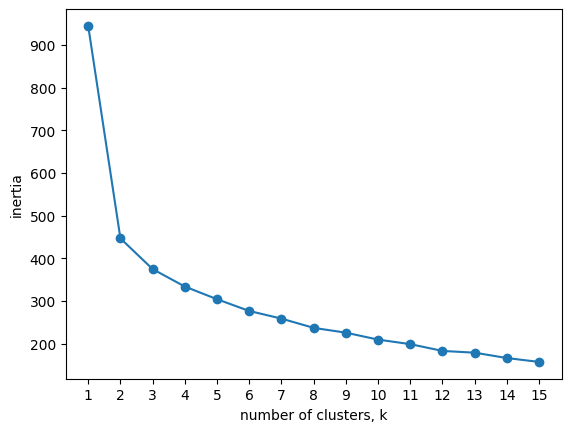

In [9]:
from sklearn.cluster import KMeans

inertia = []

ks = range(1,16)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(audio_unlabeled_scaled)
    inertia.append(kmeans.inertia_)
    
plt.plot(ks, inertia, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#### Bepaling Clusters:
Wij hebben de aantal clusters bepaald door de 'elleboogmethode' die je hierboven ziet. De elleboogmethode houdt in dat je het aantal clusters tegenover de inertia plot in een grafiek en dan kijkt waar de afname zicht afvlakt. Wij hebben dus aan de hand van de grafiek hierboven bepaald dat de optimale aantal clusters 3 is.  
Inertia is de som van squared distances binnen een cluster tussen elk data punt met de centroid van de cluster. [ChatGPT, 2024, Prompt:Elleboog methode en inertia](https://chat.openai.com/share/76f85776-a2a7-4787-88c8-2ee0cd9f3922)  
$$Inertia = \Sigma^{n}_{i=1}\Sigma^{k}_{j=1}w_{ij}||x_{i} - c_{j}||^{2}$$  
- n is het aantal datapunten.  
- k is het aantal clusters.  
- $x_{i}$ is het datapunt.  
- $c_{j}$ is het centroid.  
- $w_{ij}$ is een binary indicator variabel. Het is 1 als x in c is, anders 0.  
- $||x_{i} - c_{j}||^{2}$ is de squared Euclidean distance tussen datapunt x en centroid c.  

### Clustering:
Clustering is een veel gebruikte vorm van unsupervised learning. Bij clustering verdeel je de data in groepen waarin data in de groepen meer op elkaar lijken dan data in andere groepen.

#### K-Means clustering
[ChatGPT, 2024, Prompt: K-means clustering](https://chat.openai.com/share/76f85776-a2a7-4787-88c8-2ee0cd9f3922)  
Het wiskundige methode voor K-means is:
1. Kies aantal clusters k en kies willekeurig de centroids.
2. Bereken de Euclidean distance voor elk datapunt x met elk centroid c.
3. Verwijst de datapunten naar zijn dichtstbijzijnde cluster, dit vormt de clusters. (Hierdoor ontstaat er nieuwe centroids)
4. Bereken de nieuwe centroids door de mean te nemen van alle datapunten van de cluster.
5. Herhaal stap 2-4, totdat er niet veel of geen verschil meer komt voor de centroids. (Maximization)
6. Dan heb je de clusters gevormd met de uiteindelijke centroids en zijn datapunten.

Voorbeeld:  
Data Points:
(1, 2), (1.5, 1.8), (5, 8), (8, 8), (1, 0.6), (9, 11), (8, 2), (10, 2), (9, 3)

Initial Centroids (randomly chosen):
c1 = (1, 2), c2 = (5, 8)

Iteration 1:
1. Assignments:
   - Assign data points to the nearest centroid:
     - Cluster 1: (1, 2), (1.5, 1.8), (1, 0.6)
     - Cluster 2: (5, 8), (8, 8), (9, 11), (8, 2), (10, 2), (9, 3)

2. Updates:
   - Recalculate centroids:
     - New c1 = (1.17, 1.47)
     - New c2 = (8.17, 5.67)

Iteration 2:
1. Assignments:
   - Assign data points to the nearest centroid:
     - Cluster 1: (1, 2), (1.5, 1.8), (1, 0.6)
     - Cluster 2: (5, 8), (8, 8), (9, 11), (8, 2), (10, 2), (9, 3)

2. Updates:
   - Recalculate centroids:
     - New c1 = (1.17, 1.47)
     - New c2 = (8.17, 5.67)

Convergence is reached, as there's no change in assignments. Final clusters:
- Cluster 1: (1, 2), (1.5, 1.8), (1, 0.6)
- Cluster 2: (5, 8), (8, 8), (9, 11), (8, 2), (10, 2), (9, 3)


C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


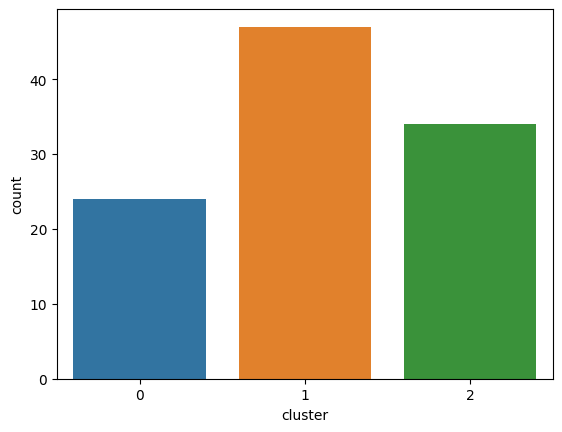

In [10]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(audio_labeled_scaled.drop('genre', axis=1))
labels = kmeans.predict(audio_unlabeled_scaled)
audio_unlabeled['cluster'] = labels
sns.countplot(data=audio_unlabeled, x=audio_unlabeled['cluster'])
plt.show()

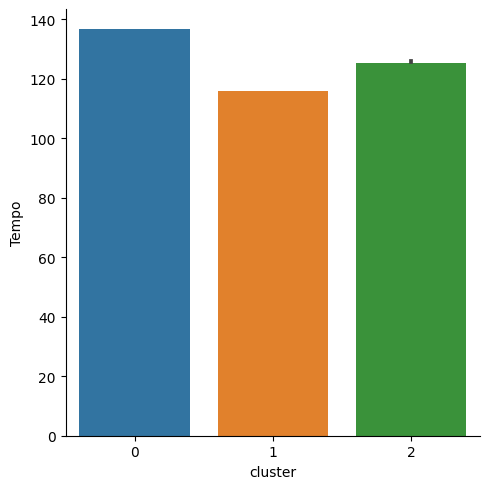

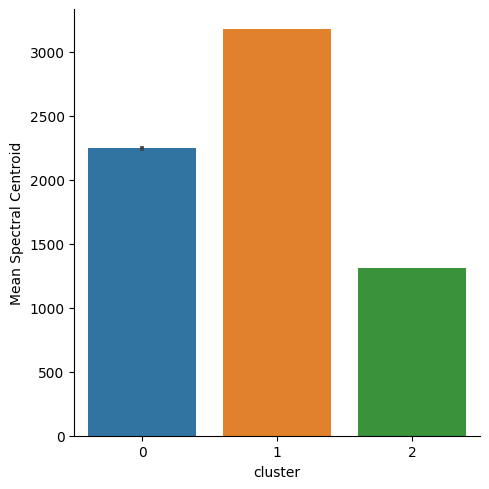

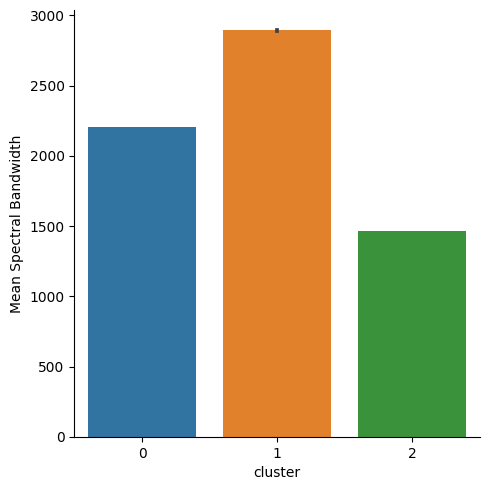

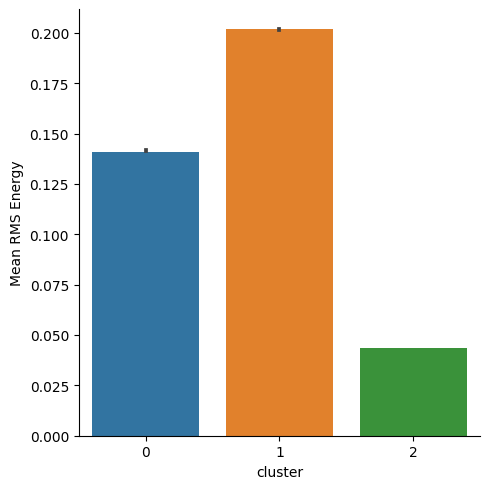

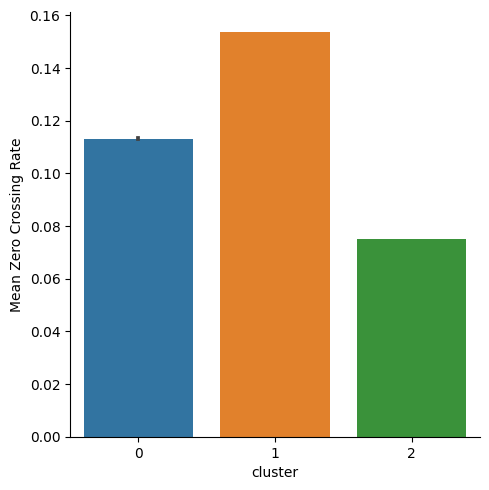

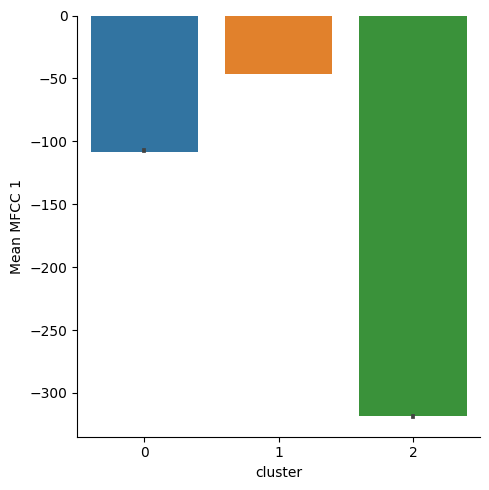

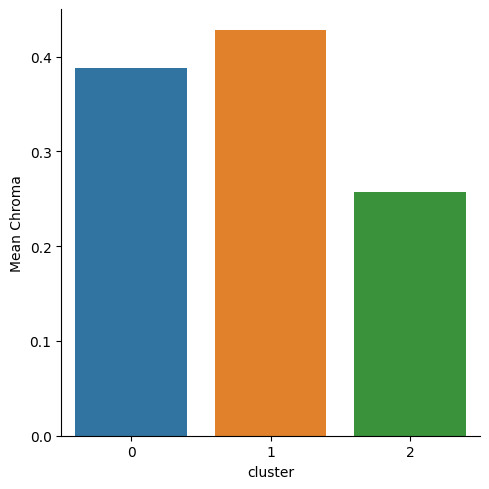

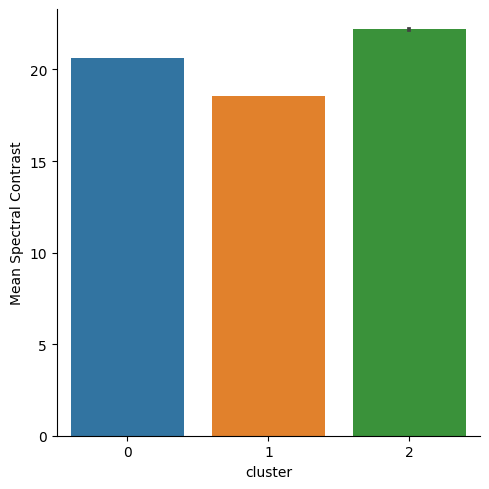

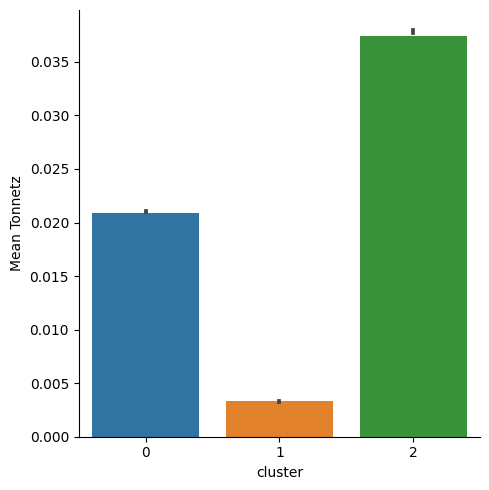

In [11]:
for col in audio_unlabeled.columns.drop('cluster'):
    sns.catplot(data=audio_unlabeled, x='cluster', y=col, kind='bar', errorbar=('ci', True))
    plt.show()

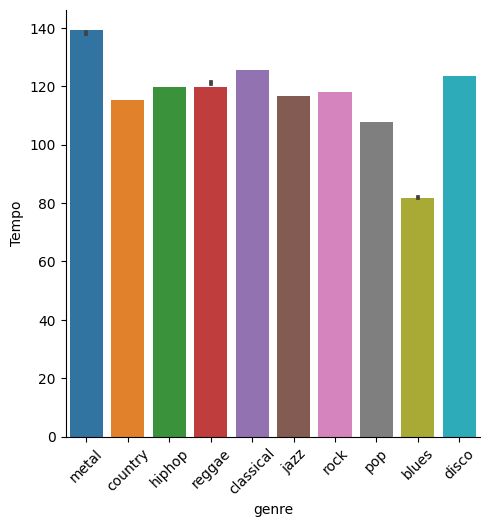

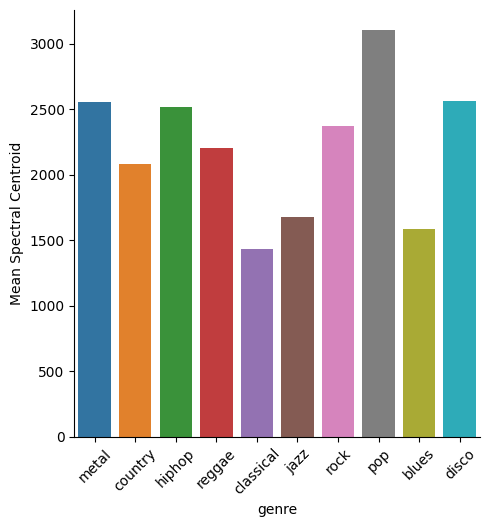

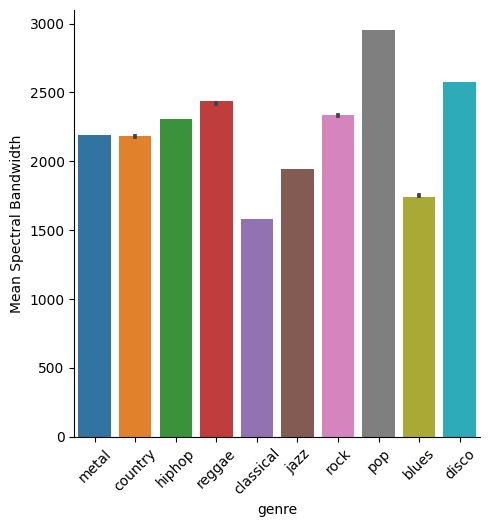

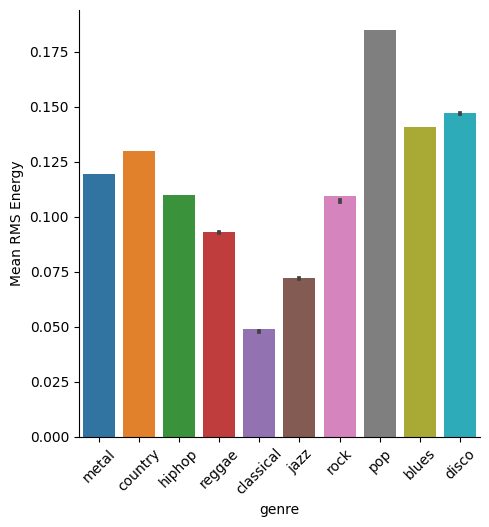

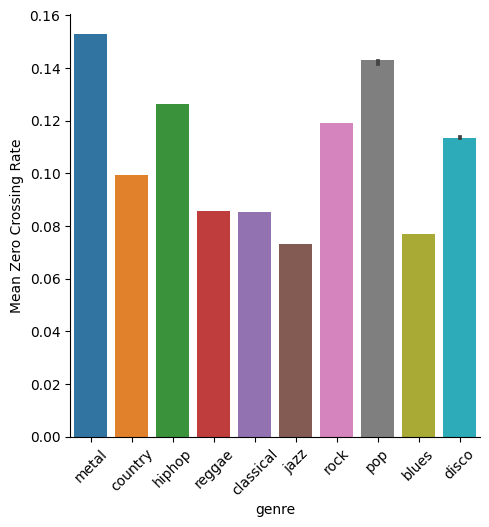

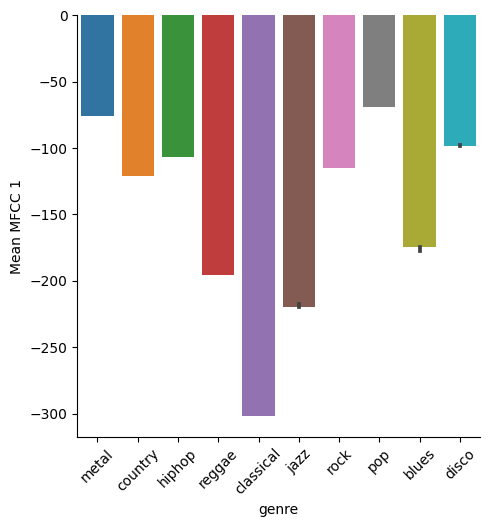

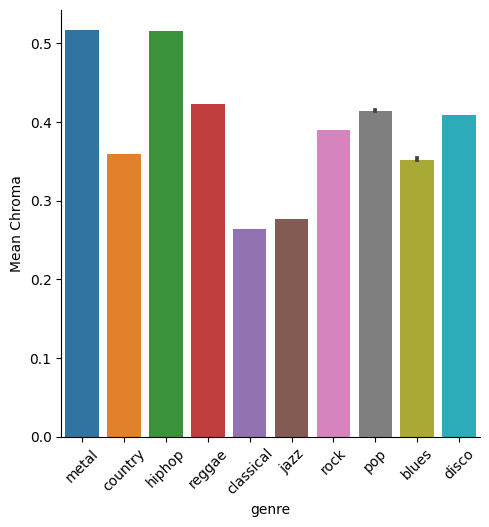

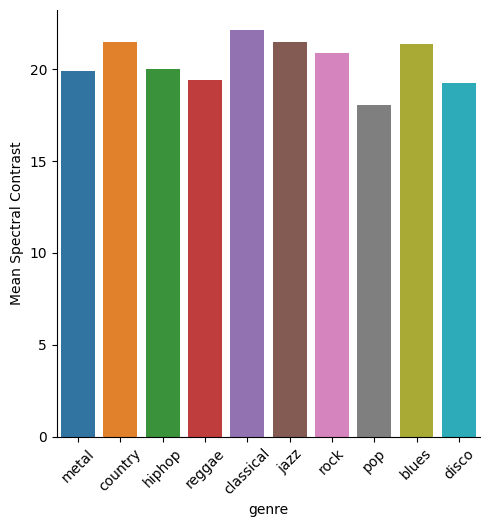

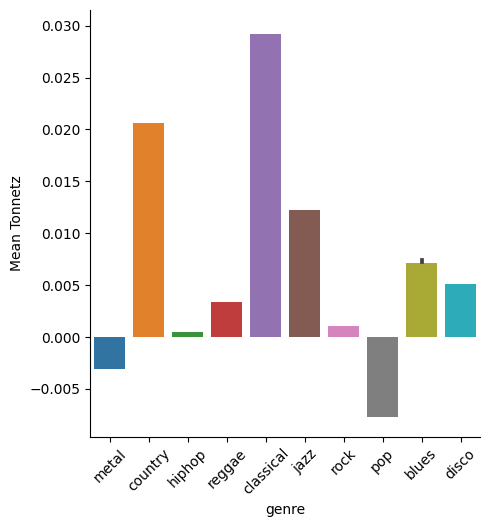

In [12]:
for col in audio_labeled.columns.drop('genre'):
    sns.catplot(data=audio_labeled, x='genre', y=col, kind='bar', errorbar=('ci', True))
    plt.xticks(rotation=45)
    plt.show()

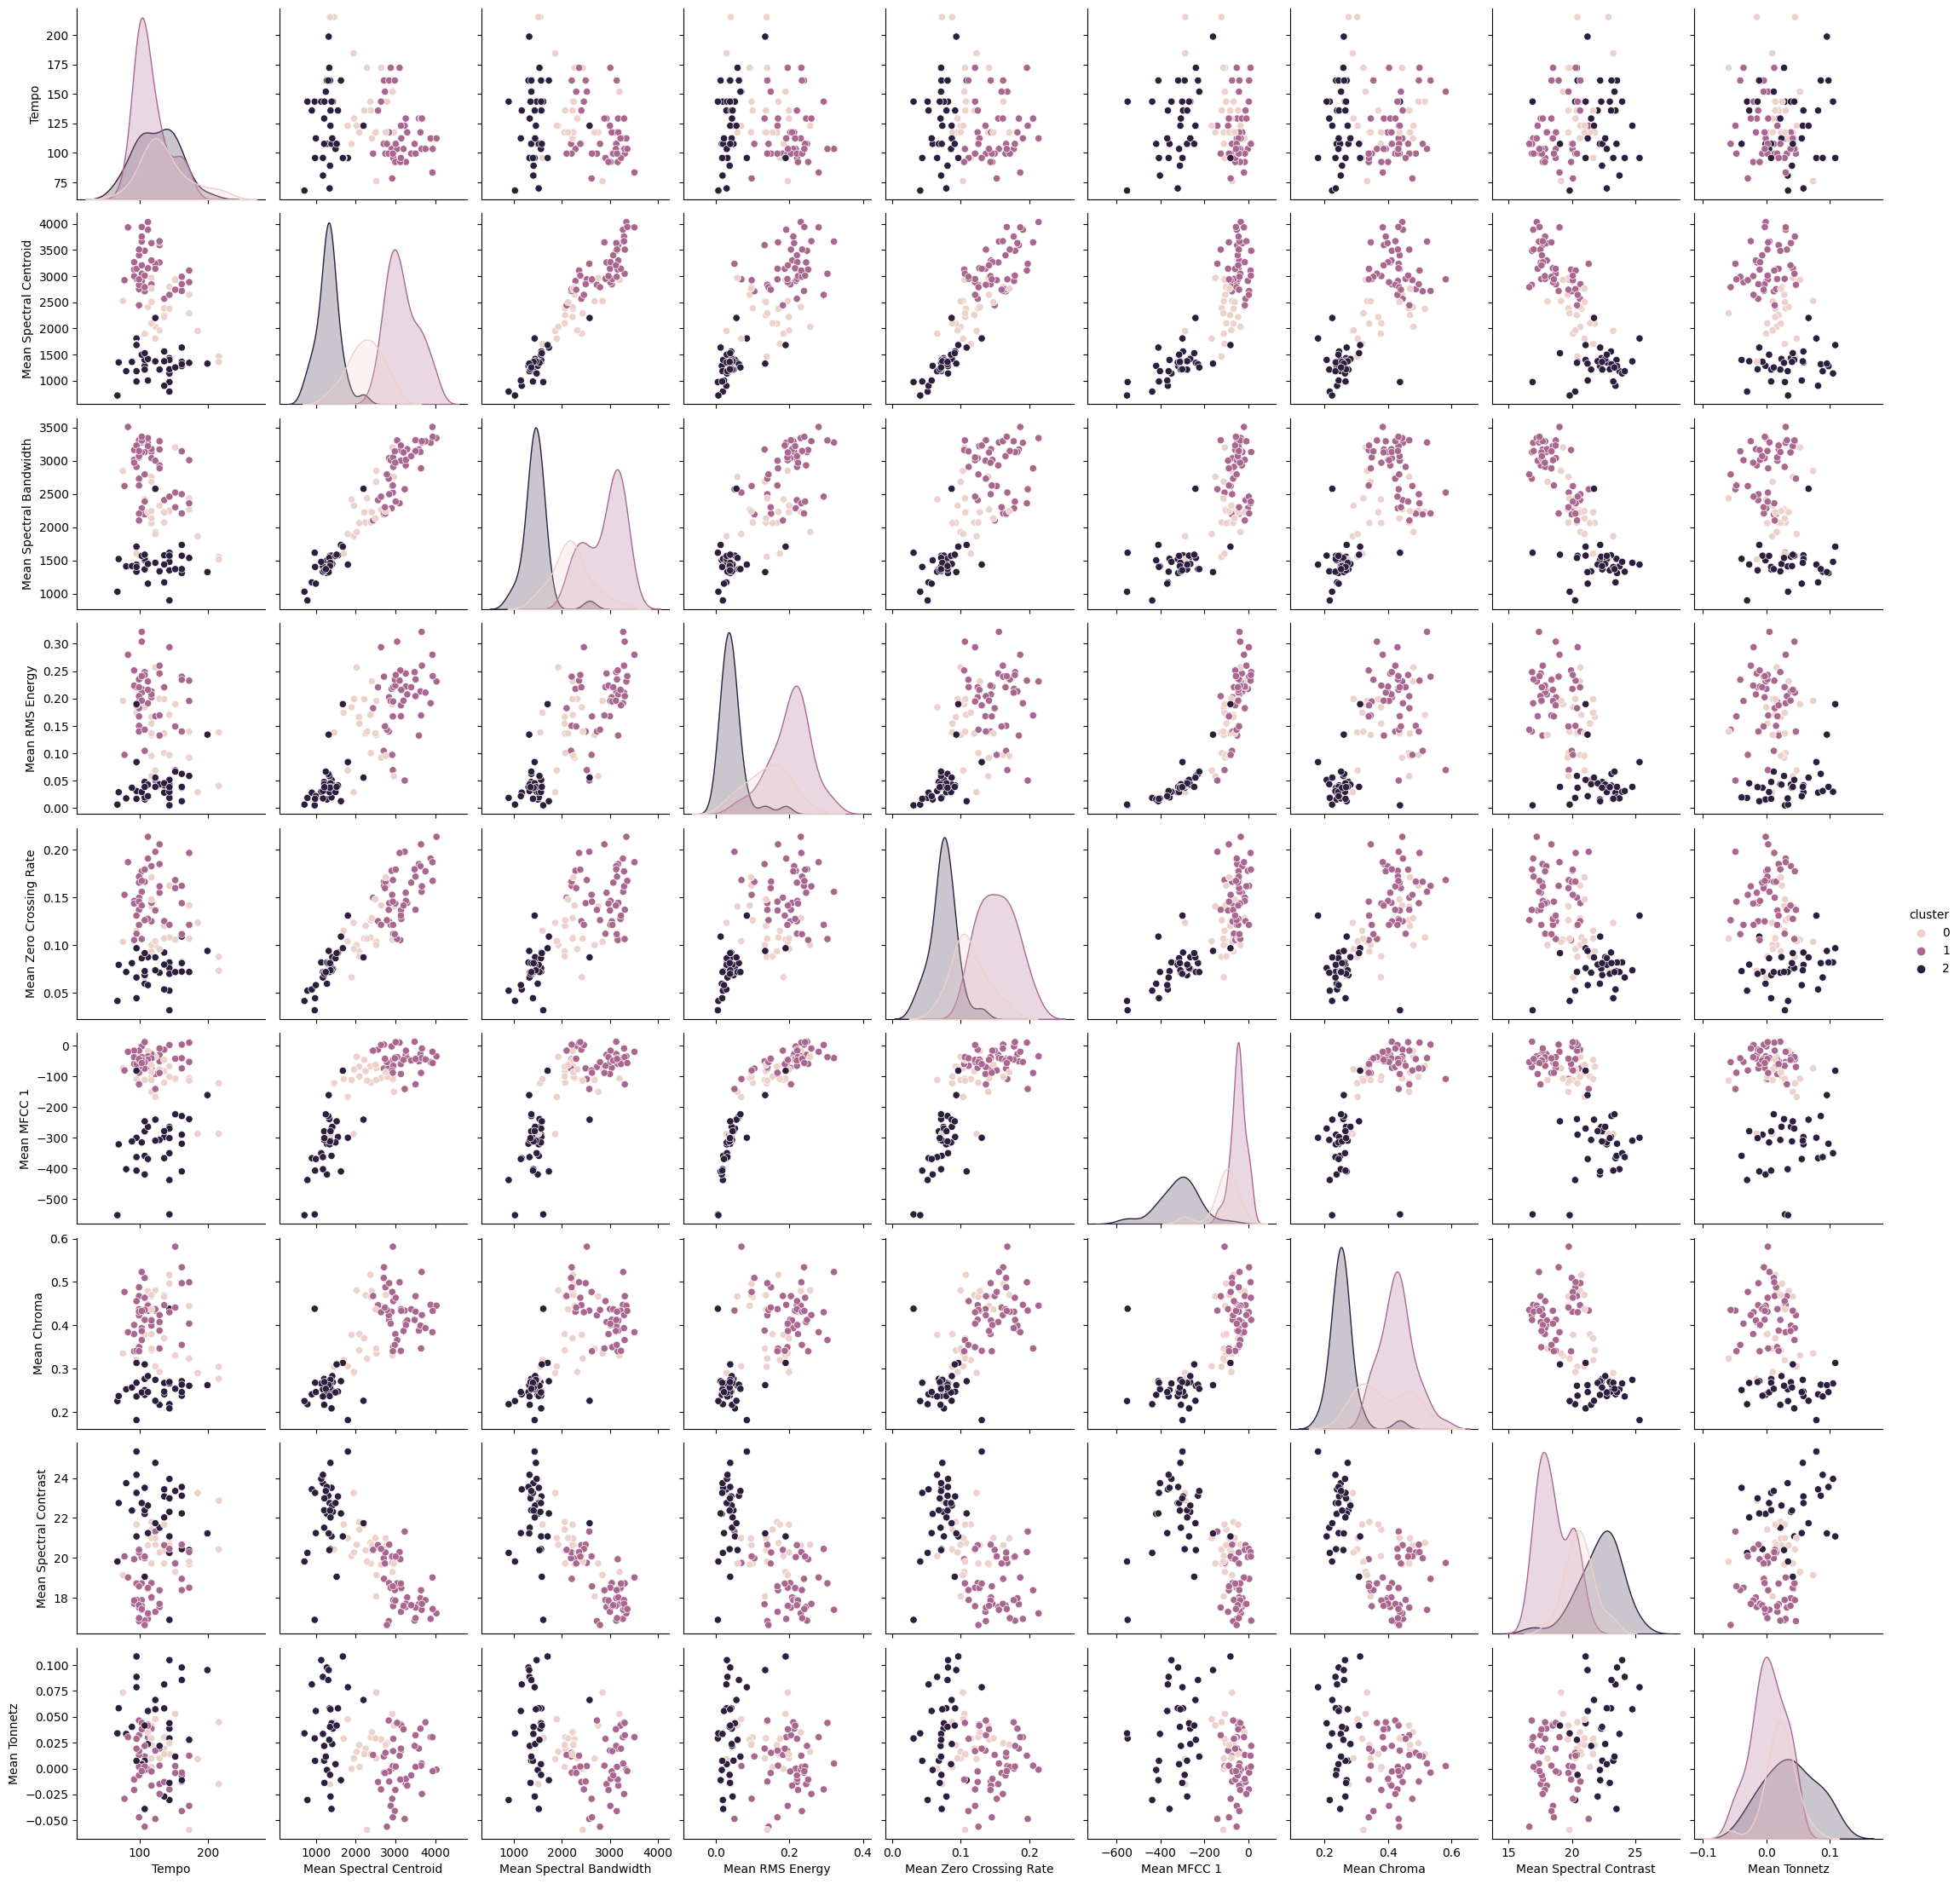

In [13]:
sns.pairplot(data=audio_unlabeled, hue='cluster')
plt.show()

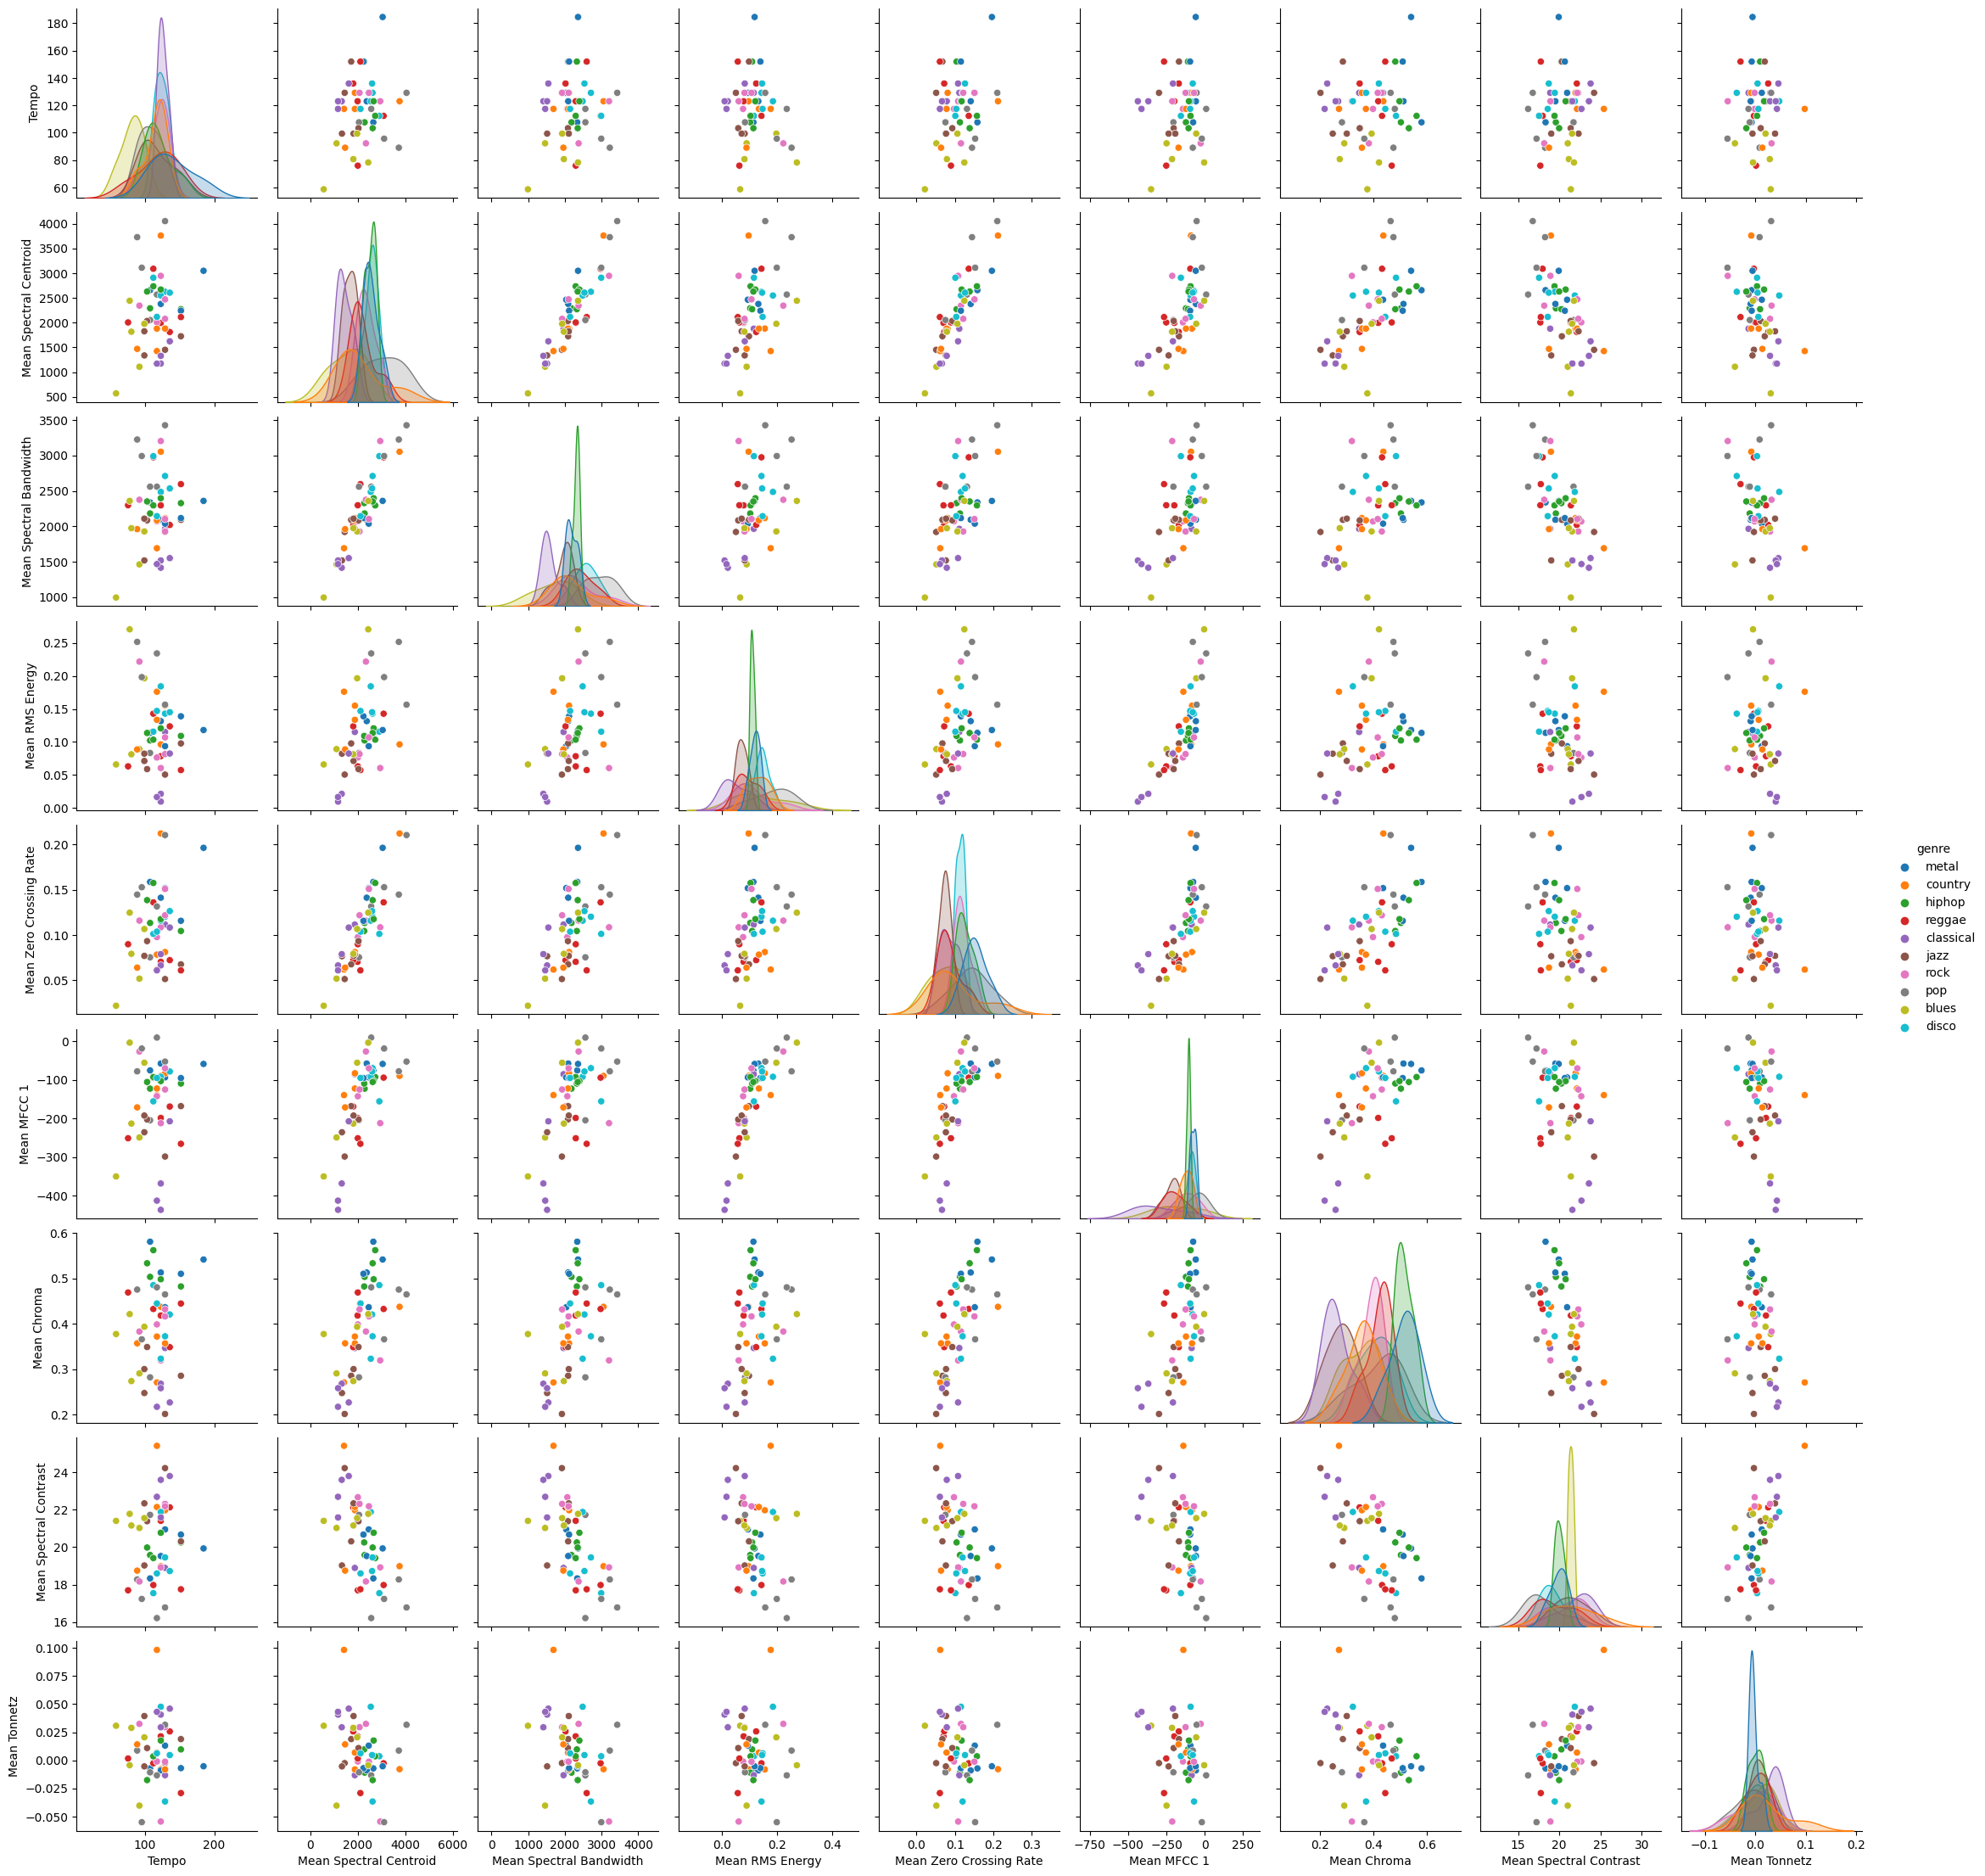

In [14]:
sns.pairplot(data=audio_labeled, hue='genre')
plt.show()

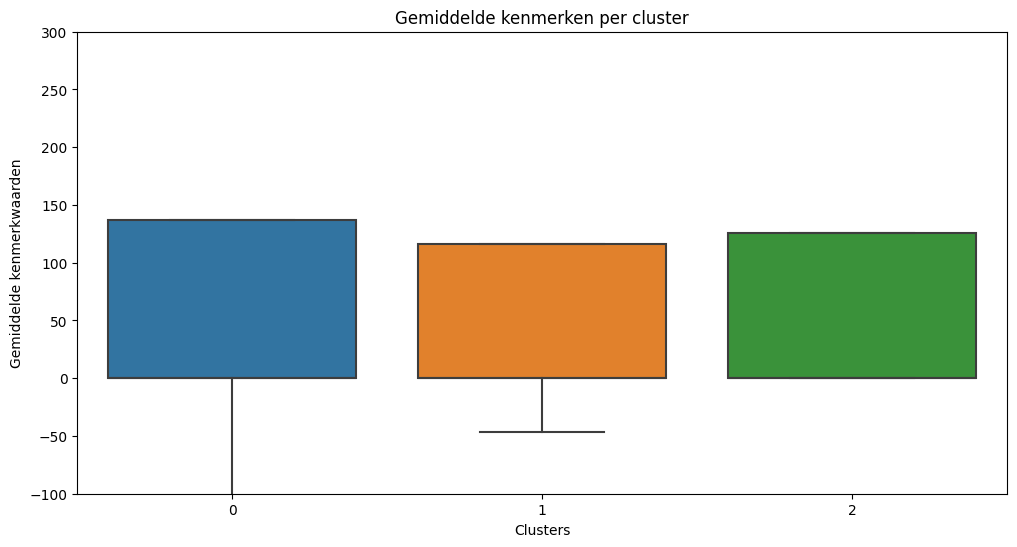

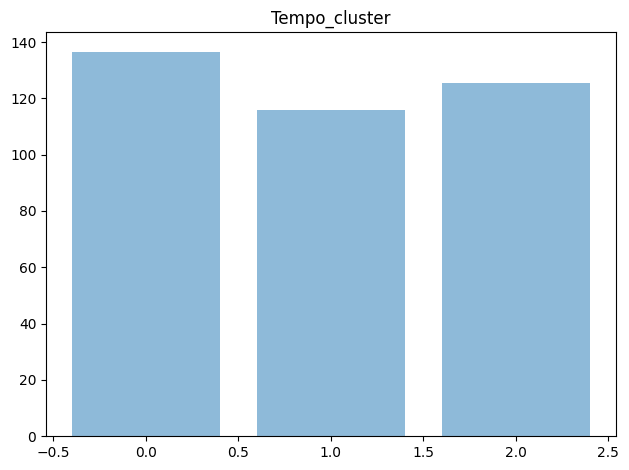

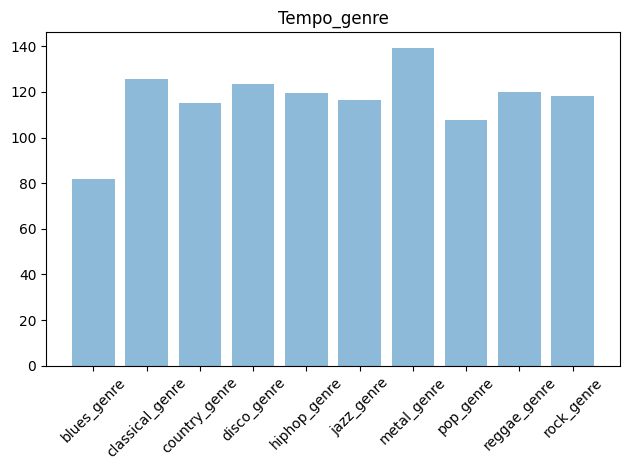

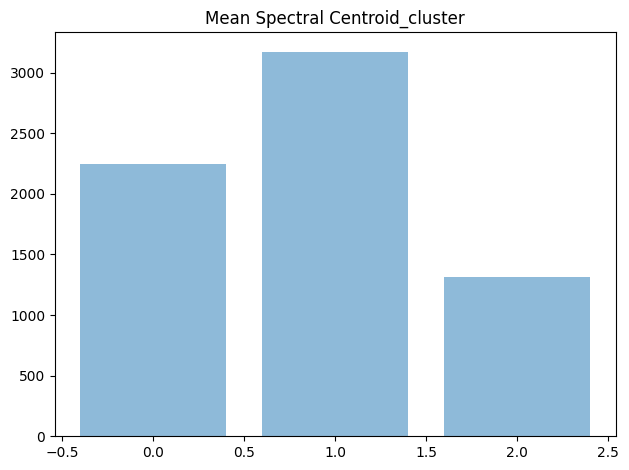

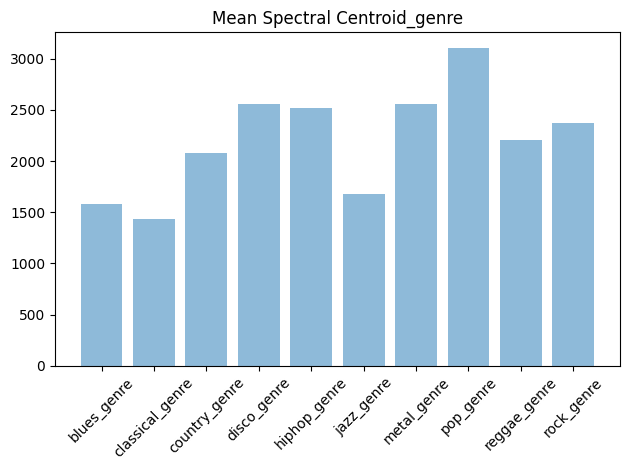

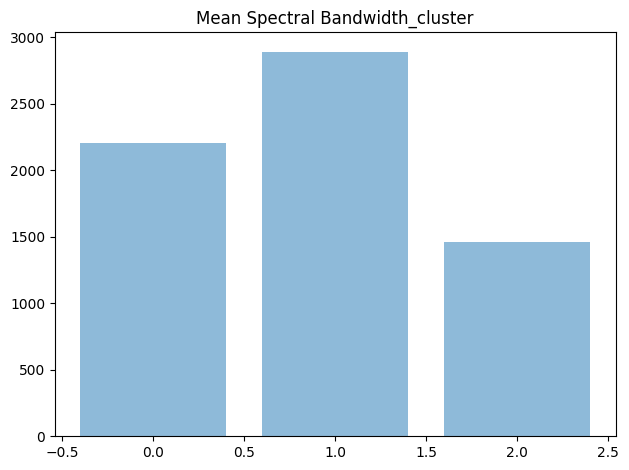

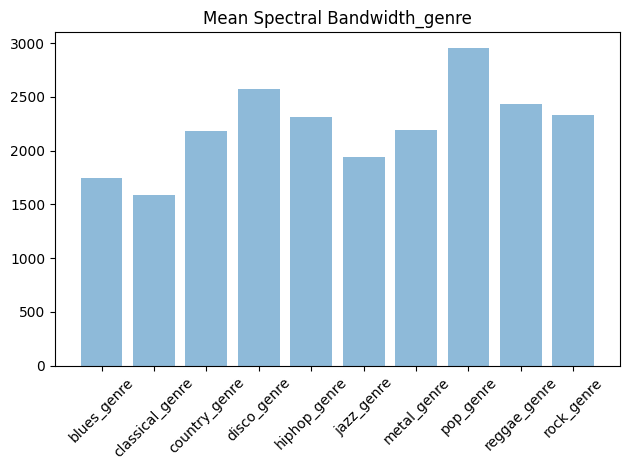

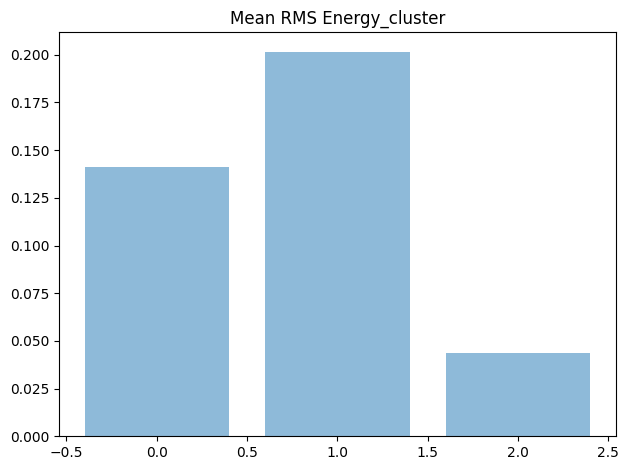

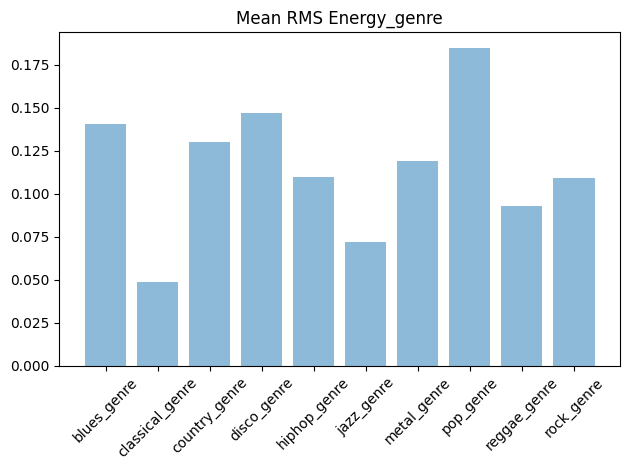

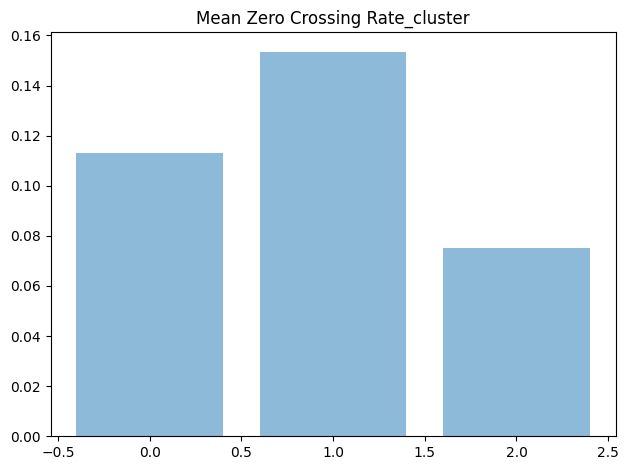

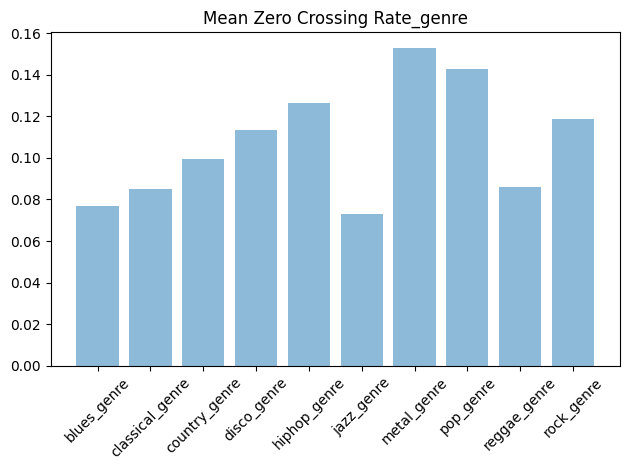

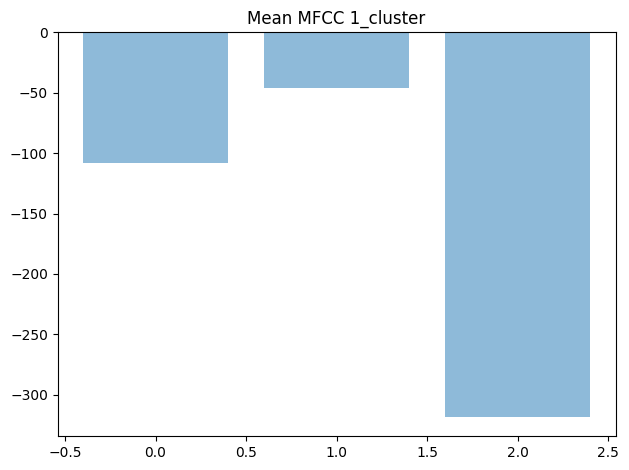

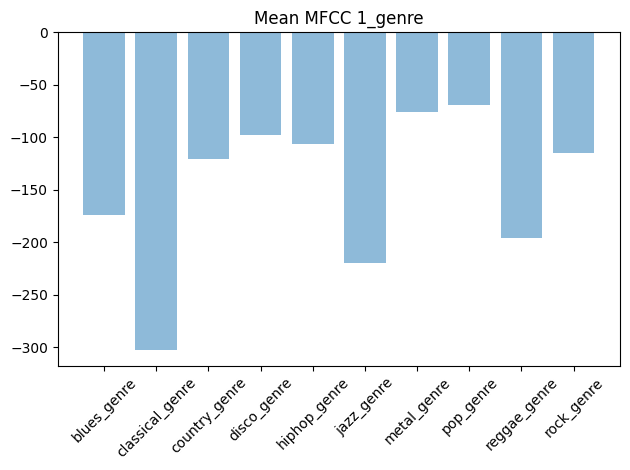

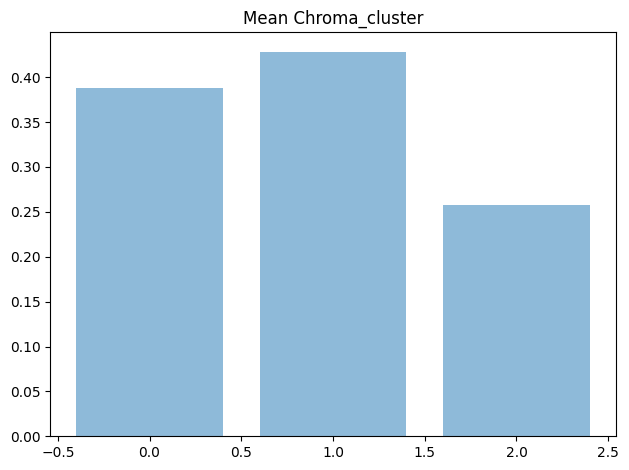

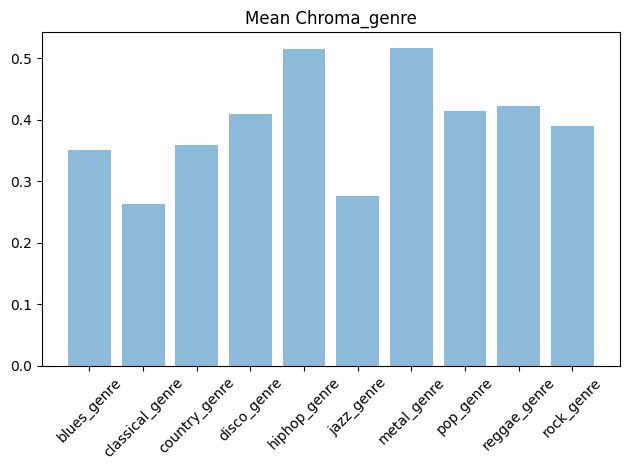

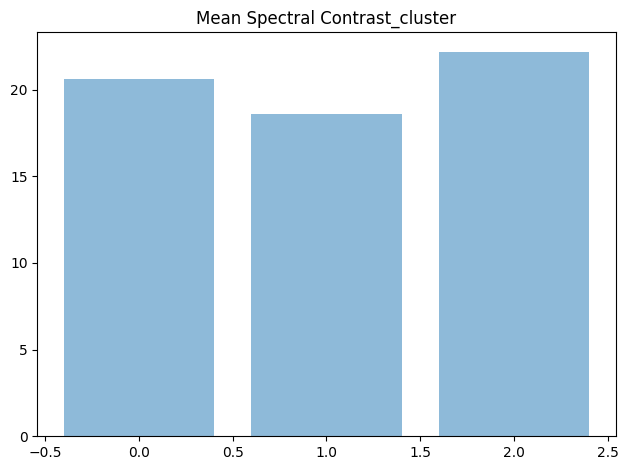

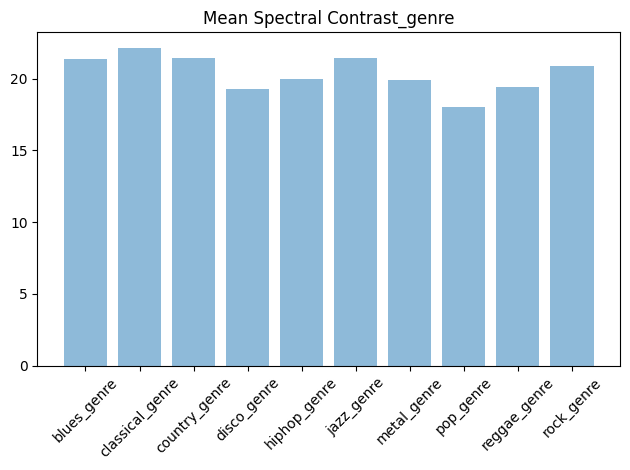

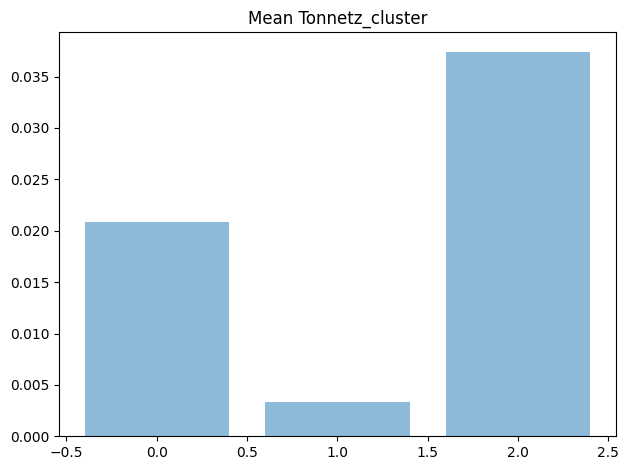

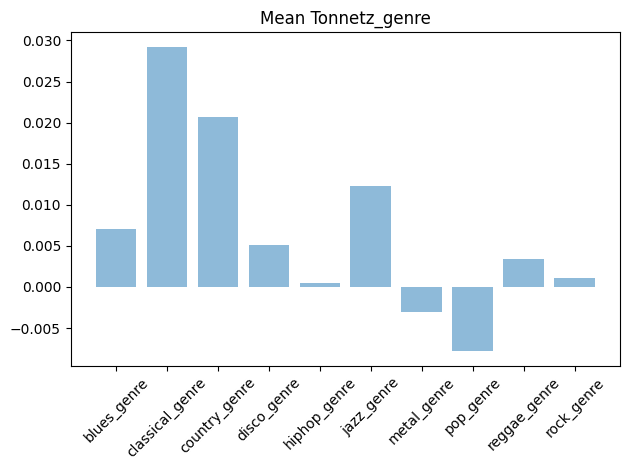

In [15]:
# Bereken gemiddelde kenmerken per cluster
cluster_means = audio_unlabeled.groupby('cluster').mean()

# Vergelijk met gelabelde dataset (verondersteld 'gelabelde_dataset' de gelabelde dataset is)
genre_means = audio_labeled.groupby('genre').mean()

# Visualisatie van kenmerken per cluster
plt.figure(figsize=(12, 6))
sns.boxplot(data=cluster_means.T)  # Transpose om kenmerken op x-as te hebben
plt.title('Gemiddelde kenmerken per cluster')
plt.xlabel('Clusters')
plt.ylabel('Gemiddelde kenmerkwaarden')
plt.ylim(-100,300)
plt.show()

for col in cluster_means.columns:
    specific_feature_to_compare = col

    plt.bar(cluster_means.index, cluster_means[specific_feature_to_compare], alpha=0.5)
    plt.title(specific_feature_to_compare + '_cluster')
    plt.tight_layout()
    plt.show()

    plt.bar(genre_means.index + '_genre', genre_means[specific_feature_to_compare], alpha=0.5)
    plt.title(specific_feature_to_compare + '_genre')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

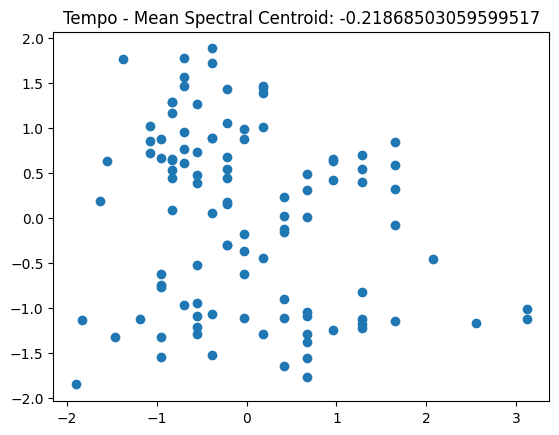

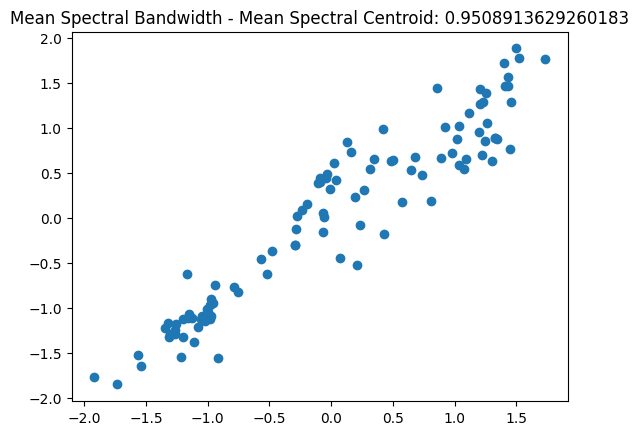

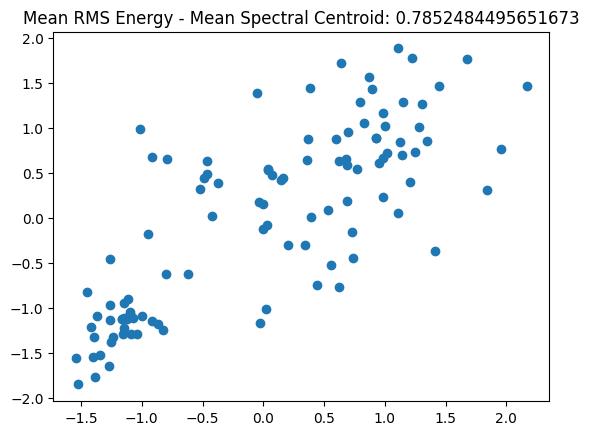

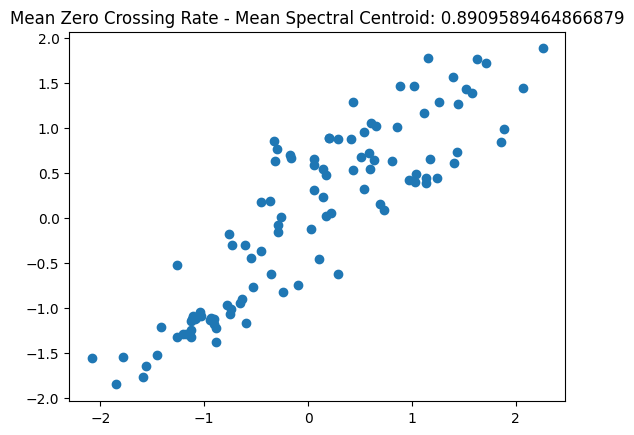

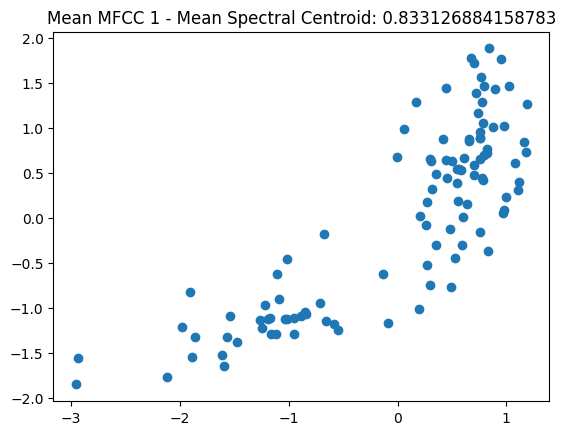

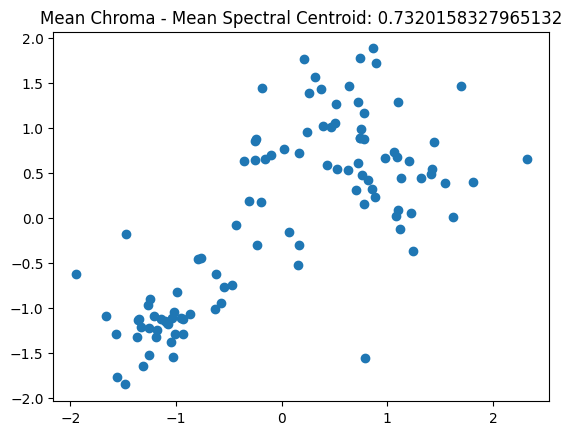

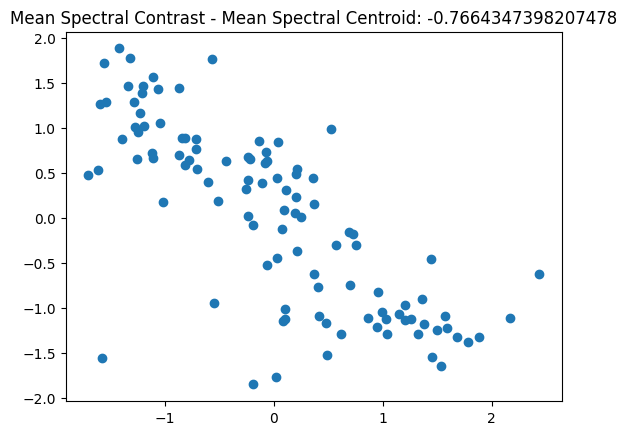

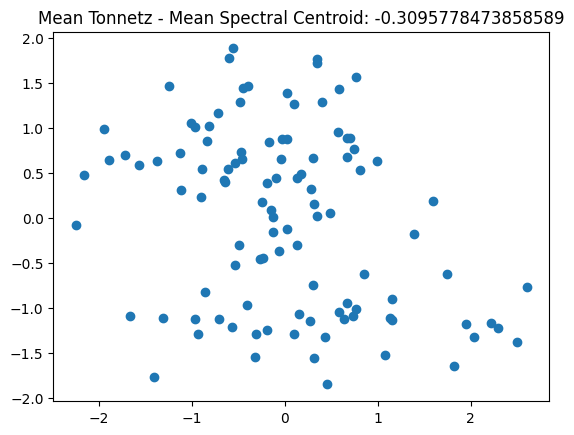

In [16]:
for col in audio_unlabeled_scaled.columns.drop('Mean Spectral Centroid'):
    plt.scatter(audio_unlabeled_scaled[col], audio_unlabeled_scaled['Mean Spectral Centroid'])
    plt.title(str(col) + ' - Mean Spectral Centroid: ' + str(np.corrcoef(audio_unlabeled_scaled[col], audio_unlabeled_scaled['Mean Spectral Centroid'])[1,0]))
    plt.show()

### PCA

PCA oftewel de principale componenten analyse wordt veel uitgevoerd op unsupervised learning. Deze techniek wordt gebruikt om dimensionaliteit
van datasets te verkleinen. Met deze techniek verhoog je hoe goed je het model kan interpreteren terwijl je de hoeveelheid informatie dat je verliest minimaliseerd. Het helpt vooral met het vinden van de belangrijkste features van de dataset. Een principale component is een lijn die het meeste van de variantie van de data pakt. Bij een pca worden de originele variabelen omgezet naar nieuwe variabelen die lineare combinaties van de originele variabelen zijn. De PCA wordt als volgt berekent:
PC_k = a_k1 * x_1 + a_k2 * x_2 + ... + a_kp * x_p
Hierbij is a_ki het gewicht van variabele x_i is op de principale component PC_i en x_i de variabele is in de gegevensmatrix van x.
De principale componenten worden zo georderd dat de meest belangrijkste variate in PC_1 zit en daarna de meest belangrijke in PC_2 enzovoort.
Om een PCA uit te voeren moet je de data eerst normaliseren.
(Biswal, 2023)

De belangrijkste verschillen tussen PCA en NMF zijn als volgt:

NMF werkt alleen met niet-negatieve getallen.

Omdat de nieuwe eigenschappen van PCA combinaties zijn van de originele eigenschappen is het vaak moeilijker de interpreteren dan bij NMF.

De resultaten van PCA zijn uniek hoewel dat bij NMF niet het geval hoeft te zijn.
[ChatGPT, 2024, Prompt: PCA vs NMF](https://chat.openai.com/share/5da612e2-597e-4739-bbf0-ab9e3cdfb160)

In [17]:
pca = PCA(n_components=5)
transformed_data = pd.DataFrame(pca.fit_transform(audio_unlabeled_scaled))
display(transformed_data)

0         1         2         3         4
0   -0.352873  0.561470  0.481236  0.531053 -0.106632
1   -1.944108 -0.160974 -0.100746  0.968418 -0.710705
2    2.131773  1.872470  0.573858  0.508267  0.417478
3   -0.251681  0.386301  0.571636  0.547454  0.546759
4    3.742073  1.306680 -1.819459 -0.757730  0.418105
..        ...       ...       ...       ...       ...
100  1.751371 -0.740431 -0.302399 -0.226913  0.835497
101 -3.262552  0.641742 -0.442555 -0.519397 -0.152989
102 -3.311416 -0.429078 -0.479025 -0.239262  0.321854
103  3.708926 -0.557889 -1.478045  0.262384 -0.246446
104  2.893607  0.942771  0.061355 -0.029642 -0.764204

[105 rows x 5 columns]

C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


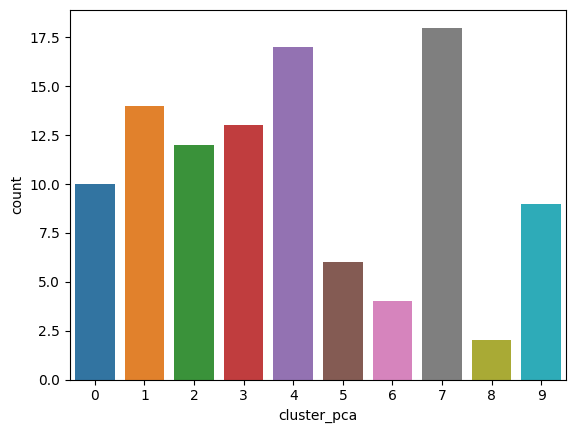

In [18]:
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(transformed_data)
audio_unlabeled['cluster_pca'] = labels
sns.countplot(data=audio_unlabeled, x=audio_unlabeled['cluster_pca'])
plt.show()

### NMF

De NMF oftewel de Non-Negative Matrix Factorization is net zoals de PCA een methode om de dimensionaliteit van een dataset te verkleinen. Een NMF wekrt alleen als de gegevens niet negatief zijn. Een NMF werkt als volgt:
Stel je hebt een matrix V met de dimensies m * n factoriseerd het in 2 nieuwe matrices namelijk matrix W met dimensies m * r en matrix H met dimensies r * n, hierbij is r de gewensten aantal factoren, m het aantal rijen en n het aantal kolommen. Matrix V is dan ook wel W * H. In matrix W zitten de features en in matrix H zit hoe belangrijk de features zijn. We willen dan dat W * H zo goed mogelijke benadering is van V. Dit kan je om meerdere manieren doen maar 1 van de meest voorkomende manieren is de multiplicatieve update-regel. Die wordt als volgt geschreven:
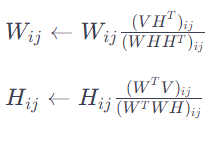
Hierbij betekent <- dat de waarde bijgewerkt wordt, i en j zijn de rij- en kolomindices en T staat voor de transpositie. Dit blijf je dan doen tot je een goede benadering hebt voor V.
[ChatGPT, 2024, Prompt: NMF: Decomposition Technique](https://chat.openai.com/share/e827366c-1b11-4094-a670-5ac3ab535c54)

De belangrijkste verschillen tussen PCA en NMF zijn als volgt:

NMF werkt alleen met niet-negatieve getallen.

Omdat de nieuwe eigenschappen van PCA combinaties zijn van de originele eigenschappen is het vaak moeilijker de interpreteren dan bij NMF.

De resultaten van PCA zijn uniek hoewel dat bij NMF niet het geval hoeft te zijn.
[ChatGPT, 2024, Prompt: PCA vs NMF](https://chat.openai.com/share/5da612e2-597e-4739-bbf0-ab9e3cdfb160)

In [19]:
scaler = MinMaxScaler()
data_matrix = scaler.fit_transform(audio_unlabeled)

# Initialize NMF with desired number of components
num_components = 3  # Choose appropriate number of components
model = NMF(n_components=num_components, init='random', random_state=0)

# Fit the model to your data
W = model.fit_transform(data_matrix)
H = model.components_

unlabeled_nmf = pd.DataFrame(W.dot(H))
display(unlabeled_nmf)

C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


0         1         2         3         4         5         6   \
0    0.400774  0.480375  0.476943  0.472560  0.486920  0.767152  0.513814   
1    0.356397  0.697033  0.731753  0.583350  0.631429  0.878945  0.591371   
2    0.374346  0.234167  0.231933  0.254359  0.288793  0.508254  0.305776   
3    0.383952  0.474243  0.472133  0.462662  0.477010  0.746498  0.500945   
4    0.268004  0.041603  0.073168  0.011904  0.100518  0.186917  0.045869   
..        ...       ...       ...       ...       ...       ...       ...   
100  0.338461  0.301263  0.341032  0.229972  0.319147  0.475838  0.257601   
101  0.336463  0.870101  0.908462  0.723495  0.758469  1.024734  0.716240   
102  0.308777  0.890193  0.933688  0.727789  0.764689  1.014864  0.712842   
103  0.354784  0.085987  0.116380  0.063531  0.159991  0.296297  0.110234   
104  0.404104  0.182682  0.219123  0.142162  0.247222  0.416076  0.189563   

           7         8         9         10  
0    0.351540  0.393269  0.129304  0.690039  
1    0.304171  0.439670  0.495777  0.520070  
2    0.450699  0.408441  0.325610  0.489970  
3    0.333413  0.378583  0.130802  0.662018  
4    0.516107  0.434958  0.887083  0.019264  
..        ...       ...       ...       ...  
100  0.513804  0.505402  0.899722  0.195904  
101  0.190639  0.398219  0.372720  0.595436  
102  0.155141  0.379513  0.397067  0.548194  
103  0.623625  0.528999  0.960571  0.130878  
104  0.670222  0.594315  1.049319  0.193831  

[105 rows x 11 columns]

C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


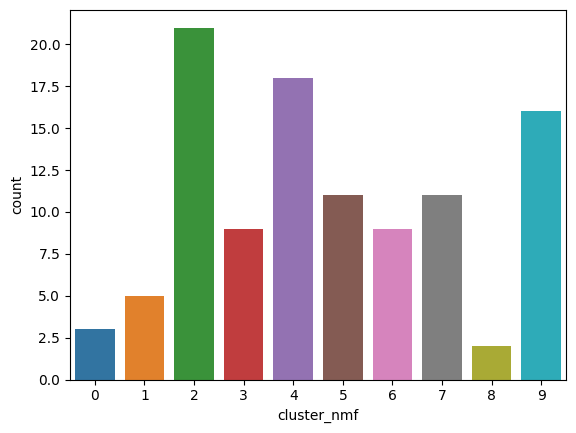

In [20]:
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(unlabeled_nmf)
audio_unlabeled['cluster_nmf'] = labels
sns.countplot(data=audio_unlabeled, x=audio_unlabeled['cluster_nmf'])
plt.show()

In [21]:
display(audio_unlabeled[['cluster','cluster_pca','cluster_nmf']])

cluster  cluster_pca  cluster_nmf
File                                         
m00003.wav        0            4            6
m00012.wav        1            4            9
m00013.wav        0            0            0
m00043.wav        0            4            6
m00044.wav        2            0            2
...             ...          ...          ...
m00971.wav        2            3            2
m00973.wav        1            7            4
m00988.wav        1            7            4
m00991.wav        2            2            2
m00995.wav        2            0            2

[105 rows x 3 columns]

In [22]:
audio_unlabeled_scaled_clusters = audio_unlabeled_scaled.copy()
audio_unlabeled_scaled_clusters.index = audio_unlabeled.index
audio_unlabeled_scaled_clusters = audio_unlabeled_scaled_clusters.merge(audio_unlabeled[['cluster', 'cluster_pca', 'cluster_nmf']], left_index=True, right_index=True)
audio_unlabeled_scaled_cluster_ = audio_unlabeled_scaled_clusters.drop(['cluster_pca', 'cluster_nmf'], axis=1)
audio_unlabeled_scaled_pca = audio_unlabeled_scaled_clusters.drop(['cluster', 'cluster_nmf'], axis=1)
audio_ulabbeled_scaled_nmf = audio_unlabeled_scaled_clusters.drop(['cluster', 'cluster_pca'], axis=1)
audio_unlabeled_scaled_clusters.head()

Tempo  Mean Spectral Centroid  Mean Spectral Bandwidth  \
File                                                                    
m00003.wav  0.416822               -0.118559                -0.282017   
m00012.wav -0.694514                0.616991                 0.019190   
m00013.wav  2.070596               -0.458375                -0.568961   
m00043.wav  0.416822                0.027751                -0.279594   
m00044.wav  0.674076               -1.765997                -1.920304   

            Mean RMS Energy  Mean Zero Crossing Rate  Mean MFCC 1  \
File                                                                
m00003.wav        -0.004922                 0.027176     0.484843   
m00012.wav         0.948568                 1.408873     1.075508   
m00013.wav        -1.262145                 0.105956    -1.018187   
m00043.wav        -0.425139                 0.169109     0.209023   
m00044.wav        -1.382432                -1.593627    -2.117474   

            Mean Chroma  Mean Spectral Contrast  Mean Tonnetz  cluster  \
File                                                                     
m00003.wav     1.123533                0.079270      0.025203        0   
m00012.wav     0.717675               -0.081216     -0.532479        1   
m00013.wav    -0.787366                1.446986     -0.265833        0   
m00043.wav     1.084537               -0.235271      0.342588        0   
m00044.wav    -1.556745                0.018301     -1.410396        2   

            cluster_pca  cluster_nmf  
File                                  
m00003.wav            4            6  
m00012.wav            4            9  
m00013.wav            0            0  
m00043.wav            4            6  
m00044.wav            0            2

In [23]:

label_encoder = LabelEncoder()
audio_labeled['genre_encoded'] = label_encoder.fit_transform(audio_labeled['genre'])


scaler = MinMaxScaler()
audio_labeled_normalized = scaler.fit_transform(audio_labeled.drop(['genre', 'genre_encoded'], axis=1))
audio_labeled_normalized = pd.DataFrame(audio_labeled_normalized, columns=audio_labeled.drop(['genre', 'genre_encoded'], axis=1).columns)

display(audio_labeled_normalized.head())


Tempo  Mean Spectral Centroid  Mean Spectral Bandwidth  Mean RMS Energy  \
0  0.388889                0.599184                 0.552139         0.398963   
1  0.511111                0.916055                 0.846324         0.332327   
2  0.388889                0.494084                 0.487908         0.354968   
3  0.511111                0.519225                 0.451237         0.467179   
4  0.511111                0.409181                 0.534852         0.263645   

   Mean Zero Crossing Rate  Mean MFCC 1  Mean Chroma  Mean Spectral Contrast  \
0                 0.718614     0.809362     1.000000                0.230340   
1                 1.000000     0.777619     0.622127                0.301084   
2                 0.480479     0.703551     0.795745                0.365919   
3                 0.627098     0.849358     0.821152                0.360161   
4                 0.254782     0.533407     0.571494                0.564634   

   Mean Tonnetz  
0      0.312411  
1      0.307775  
2      0.287715  
3      0.300615  
4      0.498554

In [24]:
audio_labeled_normalized.index = audio_labeled.index
audio_labeled_normalized.head()

Tempo  Mean Spectral Centroid  Mean Spectral Bandwidth  \
File                                                                    
m00248.wav  0.388889                0.599184                 0.552139   
m00230.wav  0.511111                0.916055                 0.846324   
m00637.wav  0.388889                0.494084                 0.487908   
m00627.wav  0.511111                0.519225                 0.451237   
m00138.wav  0.511111                0.409181                 0.534852   

            Mean RMS Energy  Mean Zero Crossing Rate  Mean MFCC 1  \
File                                                                
m00248.wav         0.398963                 0.718614     0.809362   
m00230.wav         0.332327                 1.000000     0.777619   
m00637.wav         0.354968                 0.480479     0.703551   
m00627.wav         0.467179                 0.627098     0.849358   
m00138.wav         0.263645                 0.254782     0.533407   

            Mean Chroma  Mean Spectral Contrast  Mean Tonnetz  
File                                                           
m00248.wav     1.000000                0.230340      0.312411  
m00230.wav     0.622127                0.301084      0.307775  
m00637.wav     0.795745                0.365919      0.287715  
m00627.wav     0.821152                0.360161      0.300615  
m00138.wav     0.571494                0.564634      0.498554

In [25]:
audio_labeled_normalized = audio_labeled_normalized.merge(audio_labeled[['genre_encoded', 'genre']], left_index=True, right_index=True)
audio_labeled_normalized.head(10)

Tempo  Mean Spectral Centroid  Mean Spectral Bandwidth  \
File                                                                    
m00248.wav  0.388889                0.599184                 0.552139   
m00230.wav  0.511111                0.916055                 0.846324   
m00637.wav  0.388889                0.494084                 0.487908   
m00627.wav  0.511111                0.519225                 0.451237   
m00138.wav  0.511111                0.409181                 0.534852   
m00192.wav  0.560000                0.375646                 0.398743   
m00429.wav  0.741176                0.488800                 0.547796   
m00623.wav  0.426087                0.723469                 0.813786   
m00002.wav  0.560000                0.253135                 0.380419   
m00039.wav  0.614035                0.356382                 0.421157   

            Mean RMS Energy  Mean Zero Crossing Rate  Mean MFCC 1  \
File                                                                
m00248.wav         0.398963                 0.718614     0.809362   
m00230.wav         0.332327                 1.000000     0.777619   
m00637.wav         0.354968                 0.480479     0.703551   
m00627.wav         0.467179                 0.627098     0.849358   
m00138.wav         0.263645                 0.254782     0.533407   
m00192.wav         0.404059                 0.471384     0.787478   
m00429.wav         0.381392                 0.433955     0.733260   
m00623.wav         0.510368                 0.600297     0.767425   
m00002.wav         0.156868                 0.154860     0.309351   
m00039.wav         0.436957                 0.264607     0.599664   

            Mean Chroma  Mean Spectral Contrast  Mean Tonnetz  genre_encoded  \
File                                                                           
m00248.wav     1.000000                0.230340      0.312411              6   
m00230.wav     0.622127                0.301084      0.307775              2   
m00637.wav     0.795745                0.365919      0.287715              4   
m00627.wav     0.821152                0.360161      0.300615              6   
m00138.wav     0.571494                0.564634      0.498554              8   
m00192.wav     0.382680                0.291150      0.272843              1   
m00429.wav     0.740260                0.439141      0.422461              4   
m00623.wav     0.609242                0.191782      0.342075              8   
m00002.wav     0.000000                0.870603      0.342872              5   
m00039.wav     0.387854                0.642880      0.527023              8   

                genre  
File                   
m00248.wav      metal  
m00230.wav    country  
m00637.wav     hiphop  
m00627.wav      metal  
m00138.wav     reggae  
m00192.wav  classical  
m00429.wav     hiphop  
m00623.wav     reggae  
m00002.wav       jazz  
m00039.wav     reggae

In [26]:
group_nmf = audio_unlabeled[['Tempo', 'Mean Spectral Centroid', 'Mean Spectral Bandwidth',
                             'Mean RMS Energy', 'Mean Zero Crossing Rate', 'Mean MFCC 1',
                             'Mean Chroma', 'Mean Spectral Contrast', 'Mean Tonnetz',
                             'cluster_nmf']].groupby('cluster_nmf').mean()
display(group_nmf, genre_means)

Tempo  Mean Spectral Centroid  Mean Spectral Bandwidth  \
cluster_nmf                                                                
0            174.316406             1705.134526              1760.192754   
1            110.500497             2740.277736              2831.694335   
2            119.296928             1241.659267              1419.766574   
3            128.244584             1986.272094              2046.227355   
4            108.901093             3583.773633              3183.063851   
5            133.014588             1416.248519              1533.069781   
6            139.555610             2552.362885              2274.053852   
7            104.943017             3049.344361              3090.948885   
8            147.235577             1503.781489              1517.702230   
9            133.211826             2838.793737              2455.332045   

             Mean RMS Energy  Mean Zero Crossing Rate  Mean MFCC 1  \
cluster_nmf                                                          
0                   0.046227                 0.100190  -246.930069   
1                   0.165818                 0.116227   -86.532257   
2                   0.031069                 0.069977  -346.636566   
3                   0.189202                 0.097939   -76.009552   
4                   0.225261                 0.170711   -41.485645   
5                   0.046050                 0.081721  -300.722778   
6                   0.113930                 0.136096   -98.548874   
7                   0.208623                 0.124611   -57.665306   
8                   0.161922                 0.095294  -120.888489   
9                   0.176179                 0.156365   -40.977814   

             Mean Chroma  Mean Spectral Contrast  Mean Tonnetz  
cluster_nmf                                                     
0               0.290644               22.369828      0.013935  
1               0.357312               18.348121      0.006567  
2               0.262699               21.704815      0.012765  
3               0.371621               20.962305      0.019208  
4               0.418290               17.658493      0.007230  
5               0.241348               23.317624      0.072828  
6               0.454188               20.297418      0.016724  
7               0.398066               18.210649      0.025595  
8               0.287438               21.151979      0.101791  
9               0.466083               19.972520     -0.009493

Tempo  Mean Spectral Centroid  Mean Spectral Bandwidth  \
genre                                                                    
blues       81.889631             1583.387646              1743.755155   
classical  125.749196             1435.502063              1583.313469   
country    115.251335             2083.312910              2181.117729   
disco      123.609251             2561.331810              2572.697428   
hiphop     119.683699             2519.631562              2310.307216   
jazz       116.665141             1675.108026              1944.565406   
metal      139.296301             2557.961237              2188.541721   
pop        107.825021             3102.778575              2952.233656   
reggae     119.878364             2202.812513              2436.350580   
rock       118.236861             2369.401074              2335.257509   

           Mean RMS Energy  Mean Zero Crossing Rate  Mean MFCC 1  Mean Chroma  \
genre                                                                           
blues             0.140737                 0.076771  -174.428619     0.351571   
classical         0.048953                 0.085169  -302.222717     0.263555   
country           0.129948                 0.099472  -121.193581     0.359069   
disco             0.146992                 0.113463   -98.128128     0.409466   
hiphop            0.109819                 0.126286  -106.723000     0.516144   
jazz              0.072097                 0.073069  -219.556396     0.276894   
metal             0.119193                 0.152806   -76.188950     0.516712   
pop               0.184845                 0.143026   -68.912933     0.413943   
reggae            0.093046                 0.085836  -195.835114     0.422877   
rock              0.109434                 0.118969  -115.241653     0.390078   

           Mean Spectral Contrast  Mean Tonnetz  
genre                                            
blues                   21.382800      0.007091  
classical               22.110814      0.029179  
country                 21.450688      0.020666  
disco                   19.239101      0.005122  
hiphop                  19.999706      0.000478  
jazz                    21.454712      0.012262  
metal                   19.881724     -0.003056  
pop                     18.045874     -0.007740  
reggae                  19.391925      0.003404  
rock                    20.849270      0.001036

In [34]:
from sklearn.ensemble import RandomForestClassifier
X = audio_labeled.drop(['genre', 'genre_encoded'], axis=1)  # Remove 'genre_encoded' from features
y = audio_labeled['genre']
rf = RandomForestClassifier()
rf.fit(X, y)
clust_pred = rf.predict(cluster_means[['Tempo', 'Mean Spectral Centroid', 'Mean Spectral Bandwidth',
                             'Mean RMS Energy', 'Mean Zero Crossing Rate', 'Mean MFCC 1',
                             'Mean Chroma', 'Mean Spectral Contrast', 'Mean Tonnetz']])
nmf_pred = rf.predict(group_nmf[['Tempo', 'Mean Spectral Centroid', 'Mean Spectral Bandwidth',
                             'Mean RMS Energy', 'Mean Zero Crossing Rate', 'Mean MFCC 1',
                             'Mean Chroma', 'Mean Spectral Contrast', 'Mean Tonnetz']])
print(clust_pred,nmf_pred, sep='\n')

['disco' 'pop' 'classical']
['classical' 'pop' 'classical' 'classical' 'metal' 'disco' 'pop' 'pop'
 'country' 'blues']
['jazz' 'disco' 'classical' 'country' 'pop' 'classical' 'hiphop' 'pop'
 'country' 'disco']


### app

In [35]:
from sklearn.preprocessing import normalize
def reccomendation_app(song):
    df = MinMaxScaler().fit_transform(audio_unlabeled)
    model = NMF(n_components=10, init='random', random_state=1337).fit(df)
    nmf_feat = model.transform(df)
    norm_feat = normalize(nmf_feat)
    df_nmf = pd.DataFrame(norm_feat, index=audio_unlabeled.index)
    sim = df_nmf.dot(df_nmf.loc[song]).sort_values(ascending=False)[1:]
    return sim[:5]

In [36]:
reccomendation_app('m00043.wav')

C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


File
m00211.wav    0.992455
m00003.wav    0.989416
m00061.wav    0.983553
m00581.wav    0.981713
m00149.wav    0.979975
dtype: float64

### Bevindingen en conclusie:
Het lijkt erop dat vooral Mean Chroma, Tempo, Mean Spectral Centroid en Mean RMS lijken de features te zijn die het belangrijkste zijn voor een goede clustering. Dit heb ik bepaald door de dataframe 'audio_unlabeled_scaled_clusters'te bestuderen en te concluderen dat daar het grootste verband is tussen de waardes van de variabelen en de geplaatste cluster.
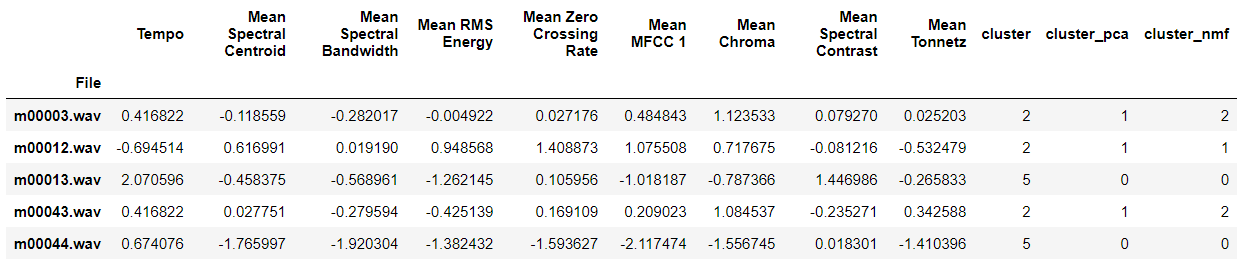
Je kan bijvoorbeeld hier in deze afbeelding zien dat bij Mean Chroma ze in cluster 2 gestopt worden bij cluster_nmf als de waarde tussen ~1.16 en ~1.41, in cluster 1 als het tussen ~-0.77 en ~1.15 en ten slot cluster 0 bij waardes lager dan ~0.77. Ik weet niet natuurlijk wat de exacte waardes voor deze clusteringen zijn maar je kan wel zien dat het dus een belangrijke feature is.
#### Dimensionality reduction:
Dimensionality reduction zorgt ervoor dat de data geenvoudigd wordt terwijl het nog wel de belangrijke informatie behoudt. Een paar van de belangrijkste dingen die het doet is het tegengaan van overfitten, vermindering van benodigde rekenkracht, het makkelijker maken van visualiseren en vermindering van ruis. [ChatGPT, 2024, Prompt: NMF: Dimensionality Reduction Benefits](https://chat.openai.com/share/fb628675-b935-42b2-9bfe-eb3f3c2d6d51)

#### Extra gegevens:


## Bronnenlijst:

[ChatGPT, 2024, Prompt: Features (sorry numpy werkte eerste niet)](https://chat.openai.com/share/65be9719-331f-412c-a338-e7233af59b13)

Biswal, A. (2023, 7 november). What is principal component analysis? Simplilearn.com. https://www.simplilearn.com/tutorials/machine-learning-tutorial/principal-component-analysis

[ChatGPT, 2024, Prompt: PCA vs NMF](https://chat.openai.com/share/5da612e2-597e-4739-bbf0-ab9e3cdfb160)

[ChatGPT, 2024, Prompt: NMF: Decomposition Technique](https://chat.openai.com/share/e827366c-1b11-4094-a670-5ac3ab535c54)

[ChatGPT, 2024, Prompt: NMF: Dimensionality Reduction Benefits](https://chat.openai.com/share/fb628675-b935-42b2-9bfe-eb3f3c2d6d51)